In [1]:
# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['text.usetex'] = True

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from fittools import *
from formattools import *
# style = styles['prd_twocol']
style = styles['notebook']

import gvar as gv
import lsqfit
import corrfitter as cf

from __future__ import print_function

try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

## Process data and show current fits

In [2]:
# Set the ensemble index.
ens_idx = 0
ensemble = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004'][ens_idx]
ens_path = ['24I/ml0p01', '24I/ml0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004'][ens_idx]
f_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + ensemble + '/fit_params.h5'
n_ops = 5

# read in input to plot
f = h5py.File(f_path, 'r')
data_slice = f['data_slice'][()]
c = f['c'][()]
sigmac = f['sigmac'][()]
plot_domain = f['plot_domain'][()]
f.close()

data_plot_mu = np.mean(data_slice, axis = 0)
data_plot_sigma = np.std(data_slice, axis = 0, ddof = 1)

In [3]:
# set specific ranges and labels
ytick_labels = [
    [['-5.8', '-5.4', '-5.0'], ['-1.0', '-0.9', '-0.8'], ['3.4', '3.6', '3.8'], ['-1.9', '-1.7', '-1.5'], ['2.1', '2.3', '2.5']],         # 24I/ml0p01
    [['-5.0', '-4.7', '-4.4'], ['-8.5', '-8.0', '-7.5'], ['1.70', '1.85', '2.00'], ['-1.55', '-1.45', '-1.35'], ['1.80', '1.95', '2.10']],      # 24I/ml0p005
    [['-1.90', '-1.75', '-1.60'], ['-2.9', '-2.7', '-2.5'], ['8.00', '8.75', '9.50'], ['-5.8', '-5.3', '-4.8'], ['6.2', '6.7', '7.2']],      # 32I/ml0p008
    [['-1.70', '-1.55', '-1.40'], ['-2.7', '-2.5', '-2.3'], ['5.7', '6.2', '6.7'], ['-5.5', '-5.0', '-4.5'], ['5.8', '6.2', '6.6']],      # 32I/ml0p006
    [['-1.55', '-1.45', '-1.35'], ['-2.40', '-2.25', '-2.10'], ['3.4', '3.8', '4.2'], ['-4.9', '-4.5', '-4.1'], ['5.2', '5.6', '6.0']],      # 32I/ml0p004
][ens_idx]
pwr = [
    [-3, -2, -4, -2, -3],
    [-3, -3, -4, -2, -3],
    [-3, -3, -5, -3, -4],
    [-3, -3, -5, -3, -4],
    [-3, -3, -5, -3, -4]
][ens_idx]              # think about doing using \\text{-}
yrangep = [
    [[-0.0060, -0.0048], [-0.0105, -0.0075], [0.00033, 0.00039], [-0.02, -0.014], [0.0020, 0.0026]],
    [[-0.0051, -0.0043], [-0.00875, -0.00725], [0.000165, 0.000205], [-0.016, -0.013], [0.00175, 0.00215]],
    [[-0.002, -0.0015], [-0.0030, -0.0024], [0.0000775, 0.0000975], [-0.0061, -0.0045], [0.00059, 0.00075]],
    [[-0.00175, -0.00135], [-0.0028, -0.0022], [0.000054, 0.00007], [-0.00575, -0.00425], [0.00056, 0.00068]],
    [[-0.0016, -0.0013], [-0.00245, -0.00205], [0.000032, 0.000044], [-0.005, -0.004], [0.0005, 0.00062]]
][ens_idx]
ytick_locs = [[round(float(ytick_labels[k][i]) * (10 ** pwr[k]), np.abs(pwr[k]) + 2) for i in range(len(ytick_labels[k]))] for k in range(n_ops)]
# yaxis_labels = ['$' + latex_labels[ii] + '^{\\mathrm{eff}} \\hspace\{-1.0mm\} \\times \\hspace{-0.5mm} 10^{' + str(pwr[ii]) + '}$' for ii in range(len(latex_labels))]

latex_labels = [r'O_1', r'O_2', r'O_3', r'O_{1^\prime}', r'O_{2^\prime}']
yaxis_labels = [r'$' + latex_labels[ii] + r'^{\mathrm{eff}} \hspace{-1.0mm} \times \hspace{-0.5mm} 10^{' + str(pwr[ii]) + r'}$' for ii in range(len(latex_labels))]

In [4]:
asp_ratio = 4/3
def plot_data(cvs, stds, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, mrk = '.', col = 'r'):
    fig_size = (style['colwidth'], style['colwidth'] / asp_ratio)
    dom = plot_domain[:len(cvs)]
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        _, caps, _ = plt.errorbar(dom, cvs, yerr = stds, fmt = mrk, c = col, \
                     capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        #plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        plt.tight_layout()
        plt.show()
def plot_fns(dom, fns, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, mrk = '.', cols = None):
    """Plots data and a function on the same figure to get an idea of what the fit parameters should tune to."""
    fig_size = (style['colwidth'], style['colwidth'] / asp_ratio)
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        for ii, fn in enumerate(fns):
            col = cols[ii] if cols else 'b'
            plt.plot(dom, [fn(t) for t in dom], c = col)
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        #plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        plt.tight_layout()
        plt.show()
def plot_data_fn(cvs, stds, fn, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, mrk = '.', col = 'r'):
    """Plots data and a function on the same figure to get an idea of what the fit parameters should tune to."""
    fig_size = (style['colwidth'], style['colwidth'] / asp_ratio)
    dom = plot_domain[:len(cvs)]
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        _, caps, _ = plt.errorbar(dom, cvs, yerr = stds, fmt = mrk, c = col, \
                     capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        plt.plot(dom, [fn(t) for t in dom], c = 'b')
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        #plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        plt.tight_layout()
        plt.show()
def plot_fit(cvs, stds, fit_x, fit_lower, fit_upper, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, \
             mrk = '.', col = 'r', Oeff_mu = None, Oeff_sigma = None, const_mu = None, const_sigma = None, \
             chi2_dof = None, saveat = None):
    """
    cvs: Central value of data points.
    stds: Standard deviation of data points.
    fit_x: x-domain to plot the fit band against (domain of the fit)
    fit_lower / fit_upper: Lower / upper band of the fit.
    ...
    Oeff_mu / Oeff_std: Mean / std value of the matrix element, extracted as fit.p['c0'].mean / .std
    const_mu / const_sigma: Mean / std value of the matrix element from a constant fit.
    """
    fig_size = (style['colwidth'], style['colwidth'] / asp_ratio)
    dom = plot_domain[:len(cvs)]    # in case plot_domain needs truncation
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        if const_mu is not None:
            plt.fill_between(dom, const_mu - const_sigma, const_mu + const_sigma, color = 'silver', alpha = 0.5, \
                             linewidth = 0.0, label = 'const $O^{\mathrm{eff}}$')
        if Oeff_mu is not None:
            plt.fill_between(fit_x, Oeff_mu - Oeff_sigma, Oeff_mu + Oeff_sigma, color = 'k', alpha = 0.5, \
                             linewidth = 0.0, label = 'exc $O^{\mathrm{eff}}$')
        _, caps, _ = plt.errorbar(dom, cvs, yerr = stds, fmt = mrk, c = col, \
                     capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
        #plt.fill_between(fit_x, fit_lower, fit_upper, color = col, alpha = 0.3, linewidth = 0.0)
        plt.fill_between(fit_x, fit_lower, fit_upper, color = col, alpha = 0.5, linewidth = 0.0, label = 'extrap')
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        if chi2_dof:
            plt.title('$\chi^2/\mathrm{dof} = $' + str(round(chi2_dof, 2)), fontsize = style['fontsize'])
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        if const_mu is not None:
            plt.legend()
        plt.tight_layout()
        if saveat:
            plt.savefig(saveat, bbox_inches='tight')
        plt.show()
def plot_fit_paper(k, cvs, stds, fit_x, fit_lower, fit_upper, yaxis_label, ylims = None, yt_locs = None, yt_labels = None, \
             mrk = '.', col = 'r', Oeff_mu = None, Oeff_sigma = None, saveat = None):
    fig_size = (style['colwidth'], style['colwidth'] / asp_ratio)
    dom = plot_domain[:len(cvs)]    # in case plot_domain needs truncation
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        if Oeff_mu is not None:
            plt.fill_between(dom, Oeff_mu - Oeff_sigma, Oeff_mu + Oeff_sigma, color = 'k', alpha = 0.2, \
                             linewidth = 0.0, label = r'$a^4\langle\pi^+ | \mathcal{O}_{' + idx_labels[k] + \
                             r'} |\pi^- \rangle$')
        _, caps, _ = plt.errorbar(dom, cvs, yerr = stds, fmt = mrk, c = col, label = 'Data', \
                     capsize = style['endcaps'], markersize = style['markersize'], elinewidth = style['ebar_width'])
        #plt.fill_between(fit_x, fit_lower, fit_upper, color = col, alpha = 0.3, linewidth = 0.0)
        plt.fill_between(fit_x, fit_lower, fit_upper, color = col, alpha = 0.4, linewidth = 0.0, label = 'Extrapolation')
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(yaxis_label, fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        if yt_locs:
            ax.set_yticks(yt_locs)
            ax.set_yticklabels(yt_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        plt.xlim(0, max(list(plot_domain)) // 2 + 1.5)
        if ylims:
            plt.ylim(ylims[0], ylims[1])
        plt.legend()
        plt.tight_layout()
        if saveat:
            plt.savefig(saveat, bbox_inches='tight')
        plt.show()
def const_fit_band(cv, std, xlims = (0, max(list(plot_domain)) // 2 + 1.5)):
    xx = np.linspace(xlims[0], xlims[1], 500)
    lower_band = np.full(xx.shape, cv - std)
    upper_band = np.full(xx.shape, cv + std)
    return xx, lower_band, upper_band
def get_fit_band(params, fcn, xlims):
    xx = np.linspace(xlims[0], xlims[1], 500)
    fx = fcn(xx, params)
    fx_lower = gv.mean(fx) - gv.sdev(fx)
    fx_upper = gv.mean(fx) + gv.sdev(fx)
    return xx, fx_lower, fx_upper

In [5]:
# Use this code block if I make this notebook into production code
f3pt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' +ensemble+ '/SD_output.h5'

f = h5py.File(f3pt_path, 'r')
L, T = f['L'][()], f['T'][()]
vol = (L**3)# * T
C2pt_tavg = f['pion-00WW'][()]
# C2WW = f['C2pt'][()]
C2_pion00WP = np.real(f['pion-00WP'][()]) / vol
C3pt_tavg = f['C3pt'][()]
Cnpt = f['Cnpt'][()]
R_boot = f['R'][()]
mpi_boot = f['mpi'][()]
f.close()

# fold 2-point WW. Note that we need this for the R-ratio, but the WP gives a cleaner 2-point signal for mpi fits
C2_fold = np.real(fold(C2pt_tavg, T))
# C2_mu = np.mean(C2_fold, axis = 0)
# C2_sigma = np.std(C2_fold, axis = 0, ddof = 1)

# get WP pion mass
meff = get_cosh_effective_mass(C2_pion00WP)
C2_folded = np.real(fold(C2_pion00WP, T))
C2_mu = np.mean(C2_folded, axis = 0)
C2_sigma = np.std(C2_folded, axis = 0, ddof = 1)
meff_folded = fold_meff(meff, T)
meff_mu = np.mean(meff_folded, axis = 0)
meff_sigma = np.std(meff_folded, axis = 0, ddof = 1)

# process data points and make ready to fit
R_mu = np.mean(R_boot, axis = 0)
R_sigma = np.std(R_boot, axis = 0, ddof = 1)
data_slice = np.zeros((n_boot, n_ops, T), dtype = np.float64)
plot_domain = range(T)
for i in range(n_ops):
    for sep in range(T):
        if sep % 2 == 0:
            data_slice[:, i, sep] = np.real(R_boot[:, i, sep // 2, sep])
        else:
            data_slice[:, i, sep] = np.real((R_boot[:, i, sep // 2, sep] + R_boot[:, i, sep // 2 + 1, sep]) / 2)
data_plot_mu = np.mean(data_slice, axis = 0)
data_plot_sigma = np.std(data_slice, axis = 0, ddof = 1)

/Users/theoares/lqcd/0nubb/python_scripts/utils.py:222: ComplexWarning: Casting complex values to real discards the imaginary part
  folded[:, 0] = C[:, 0]
/Users/theoares/lqcd/0nubb/python_scripts/utils.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  folded[:, t + 1] = (C[:, t + 1] + C[:, T - (t + 1)]) / 2


## Fit mpi

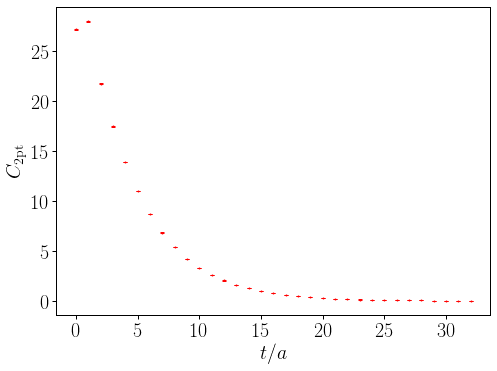

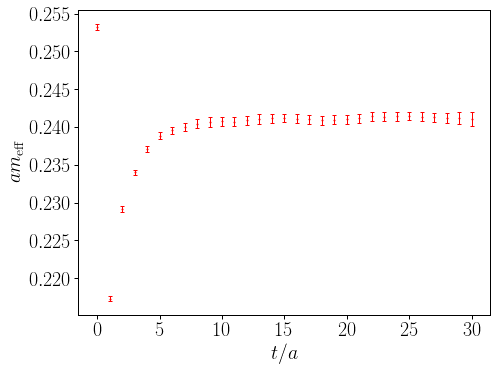

In [6]:
# plot 2-points
plot_data(C2_mu, C2_sigma, '$C_{2\mathrm{pt}}$')  # '$C_{2\mathrm{pt}}$'
plot_data(meff_mu, meff_sigma, '$am_{\mathrm{eff}}$')

#### Constant fits of effective mass to a given range (my code)

In [7]:
def const(params):
    def model(t):
        return params[0]
    return model
constant_model = Model(const, 1, [''], ['c0'])

In [8]:
mpi_domain = np.arange(12, 29)
fitter = BootstrapFitter(mpi_domain, meff_folded[:, mpi_domain], constant_model)
# fitter = UncorrFitter(mpi_domain, meff_mu[mpi_domain], meff_sigma[mpi_domain], constant_model)
mpi_params_c, chi2_c, ndof_c, mpi_covar_c = fitter.fit()
mpi_mu_c = mpi_params_c[0]
mpi_std_c = np.sqrt(mpi_covar_c[0, 0])
print('Mpi = ' + export_float_latex(mpi_mu_c, mpi_std_c) + ' with chi^2 / ndof = ' + str(chi2_c / ndof_c))

Fitting data: [0.24088537 0.24106981 0.2411842  0.24119753 0.24111457 0.24104779
 0.24091662 0.24098463 0.2410112  0.24117734 0.24141461 0.24138038
 0.24141176 0.24146834 0.24136726 0.24130491 0.24122686] at x positions: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28]
Mpi = 0.24125(38) with chi^2 / ndof = 1.4453391072387105


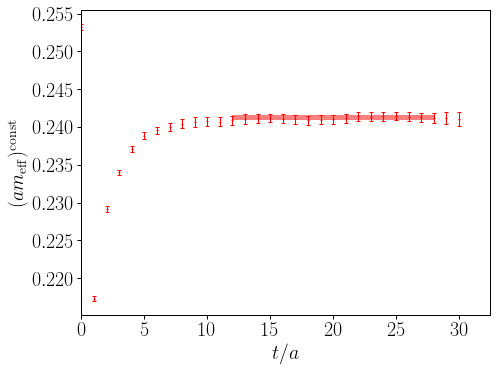

In [9]:
fit_x, fit_lower, fit_upper = const_fit_band(mpi_mu_c, mpi_std_c, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(meff_mu, meff_sigma, fit_x, fit_lower, fit_upper, '$(am_{\mathrm{eff}})^{\mathrm{const}}$')

#### Constant fits of effective mass with lsqfit and corrfitter

Need to figure out how to interface my current workflow with lsqfit and corrfitter. It looks like I'll need to specify the following things: a make_data() function (or just do it myself with my given data), a make_models() function, N (number of terms in the fit form), a make_prior() function, and a print_results() function.
- data: This is a dictionary mapping {times -> bootstrap_array}, i.e. we should send each time we want to fit to the 50-dim np.array

In [10]:
# assemble data into correct form
def make_data(corr, domain):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T).
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    cov = np.array(df.cov())
    return domain, gv.gvar(mean, cov)

In [11]:
def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['m'] = gv.gvar(0.0, 1.0)
    return prior

def fcn(t, p):
    """Constant fitting function f(t) = m."""
    m = p['m']
    return m + 0*t

# def fitargs(z):
#     prior = gv.BufferDict() 
#     prior['m'] = gv.gvar(gv.gvar(fit.p['a'].mean, z[0]))
#     return dict(prior=prior, fcn=fcn, data=(x,y))

In [12]:
#mpi_domain = np.arange(12, 29)
mpi_domain = np.arange(16, 29)
t_dom, meff = make_data(meff_folded, mpi_domain)
prior = make_prior()
p0 = None
fit = lsqfit.nonlinear_fit(data = (t_dom, meff), fcn = fcn, prior = prior, p0 = p0)
print(fit)
mean_c, std_c = fit.p['m'].mean, fit.p['m'].sdev

Least Square Fit:
  chi2/dof [dof] = 1.2 [13]    Q = 0.29    logGBF = 91.424

Parameters:
              m   0.24161 (44)      [  0.0 (1.0) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 4/0.0)
  fitter = scipy_least_squares    method = trf



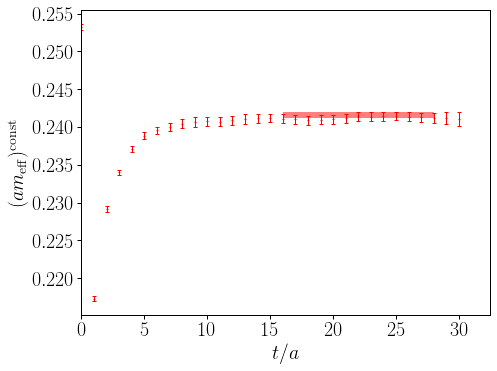

In [13]:
fit_x, fit_lower, fit_upper = get_fit_band(fit.p, fcn, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(meff_mu, meff_sigma, fit_x, fit_lower, fit_upper, '$(am_{\mathrm{eff}})^{\mathrm{const}}$')

#### Ground state fits of $m_\pi$ to correlator data with lsqfit

In [14]:
def make_data(corr, domain):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T).
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    cov = np.array(df.cov())
    return mpi_domain, gv.gvar(mean, cov)

def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    #prior['Z'] = gv.gvar('0.1(5)')
    prior['Z'] = gv.gvar(40, 40)
    prior['m'] = gv.gvar(0.25, 0.05)
    #prior['m'] = gv.gvar('0.24161(44)')
    return prior

def fcn(t, p):
    """Single exponential fitting function f(t) = Z e^{-mt}."""
    Z = p['Z']
    m = p['m']
    return Z * np.exp(-m * t)

# def fitargs(z):
#     prior = gv.BufferDict() 
#     prior['m'] = gv.gvar(gv.gvar(fit.p['a'].mean, z[0]))
#     return dict(prior=prior, fcn=fcn, data=(x,y))

In [15]:
mpi_domain = np.arange(10, 20)    # domain to modify
# mpi_domain = np.arange(10, 16)    # domain to modify
t_dom, C2 = make_data(C2_folded, mpi_domain)
prior = make_prior()
p0 = None
fit = lsqfit.nonlinear_fit(data = (t_dom, C2), fcn = fcn, prior = prior, p0 = p0)
print(fit)
mean_c, std_c = fit.p['m'].mean, fit.p['m'].sdev
Z_mu, Z_std = fit.p['Z'].mean, fit.p['Z'].sdev

Least Square Fit:
  chi2/dof [dof] = 1.4 [10]    Q = 0.17    logGBF = 58.224

Parameters:
              Z     36.94 (16)      [    40 (40) ]  
              m   0.24069 (49)      [ 0.250 (50) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 5/0.0)
  fitter = scipy_least_squares    method = trf



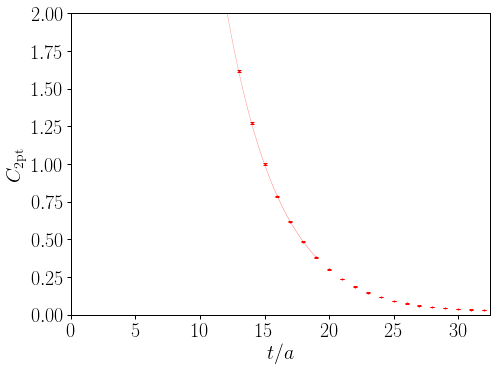

In [16]:
fit_x, fit_lower, fit_upper = get_fit_band(fit.p, fcn, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(C2_mu, C2_sigma, fit_x, fit_lower, fit_upper, '$C_{2\mathrm{pt}}$', ylims = (0, 2))

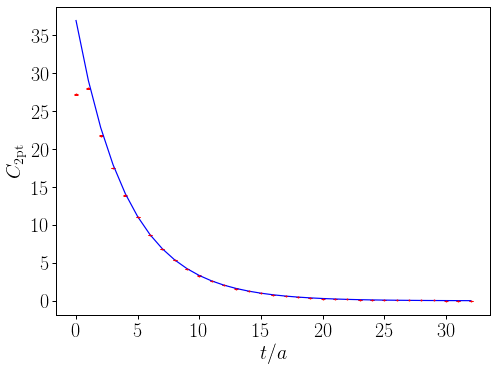

In [17]:
def trial_fn(t):
    #return (5e5) * np.exp(-0.24 * t)
    return Z_mu * np.exp(-mean_c * t)
plot_data_fn(C2_mu, C2_sigma, trial_fn, '$C_{2\mathrm{pt}}$')

#### Try a counter-propagating exponential and to add more data with t > 20

In [18]:
def make_data(corr, domain):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T).
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    cov = np.array(df.cov())
    return mpi_domain, gv.gvar(mean, cov)

def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['Z0'] = gv.gvar(40, 40)
    prior['Z1'] = gv.gvar(40, 40)
    prior['m'] = gv.gvar(0.25, 0.05)
    #prior['m'] = gv.gvar('0.24161(44)')
    return prior

def fcn(t, p):
    """Exponential fitting function f(t) = Z0 e^{-mt} + Z1 e^{-m(T - t)}."""
    Z0 = p['Z0']
    Z1 = p['Z1']
    m = p['m']
    return Z0 * np.exp(-m * t) + Z1 * np.exp(-m * (T - t))

In [19]:
# mpi_domain = np.arange(10, 25)    # domain to modify
mpi_domain = np.arange(9, 25)    # domain to modify
t_dom, C2 = make_data(C2_folded, mpi_domain)
prior = make_prior()
p0 = None
fit = lsqfit.nonlinear_fit(data = (t_dom, C2), fcn = fcn, prior = prior, p0 = p0)
print(fit)
mean_c, std_c = fit.p['m'].mean, fit.p['m'].sdev
Z0_mu, Z0_std = fit.p['Z0'].mean, fit.p['Z0'].sdev
Z1_mu, Z1_std = fit.p['Z1'].mean, fit.p['Z1'].sdev

Least Square Fit:
  chi2/dof [dof] = 0.94 [16]    Q = 0.52    logGBF = 111.44

Parameters:
             Z0     36.94 (12)      [    40 (40) ]  
             Z1     34.71 (88)      [    40 (40) ]  
              m   0.24081 (39)      [ 0.250 (50) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 5/0.0)
  fitter = scipy_least_squares    method = trf



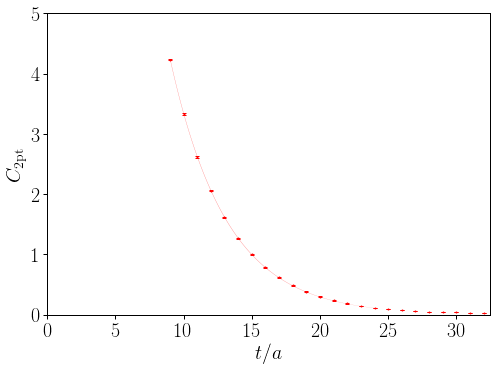

In [20]:
fit_x, fit_lower, fit_upper = get_fit_band(fit.p, fcn, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(C2_mu, C2_sigma, fit_x, fit_lower, fit_upper, '$C_{2\mathrm{pt}}$', ylims = (0, 5))

#### Excited state fits with lsqfit

In [21]:
def make_data(corr, domain):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T).
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    cov = np.array(df.cov())
    return mpi_domain, gv.gvar(mean, cov)

def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['Z0'] = gv.gvar(40, 40)
    prior['Z1'] = gv.gvar(40, 40)
    #prior['Z2'] = gv.gvar(20, 40)
    prior['Z2'] = gv.gvar(0, 20)
    prior['m'] = gv.gvar(0.25, 0.05)
    prior['dE'] = gv.gvar(0.1, 0.1)
    return prior

def fcn(t, p):
    """Exponential fitting function f(t) = Z0 e^{-mt} + Z1 e^{-m(T - t)}."""
    Z0 = p['Z0']
    Z1 = p['Z1']
    Z2 = p['Z2']
    m = p['m']
    dE = p['dE']
    return Z0 * np.exp(-m * t) + Z1 * np.exp(-m * (T - t)) + Z2 * np.exp(-(m + dE) * t)

In [22]:
# mpi_domain = np.arange(7, 25)    # domain to modify
mpi_domain = np.arange(7, 18)    # domain to modify
t_dom, C2 = make_data(C2_folded, mpi_domain)
prior = make_prior()
p0 = None
fit = lsqfit.nonlinear_fit(data = (t_dom, C2), fcn = fcn, prior = prior, p0 = p0)
print(fit)
mean_c, std_c = fit.p['m'].mean, fit.p['m'].sdev
Z0_mu, Z0_std = fit.p['Z0'].mean, fit.p['Z0'].sdev
Z1_mu, Z1_std = fit.p['Z1'].mean, fit.p['Z1'].sdev

Least Square Fit:
  chi2/dof [dof] = 0.76 [11]    Q = 0.68    logGBF = 57.771

Parameters:
             Z0     37.74 (63)      [    40 (40) ]  
             Z1        42 (32)      [    40 (40) ]  
             Z2     -1.79 (48)      [     0 (20) ]  
              m   0.24154 (83)      [ 0.250 (50) ]  
             dE     0.160 (77)      [  0.10 (10) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 13/0.0)
  fitter = scipy_least_squares    method = trf



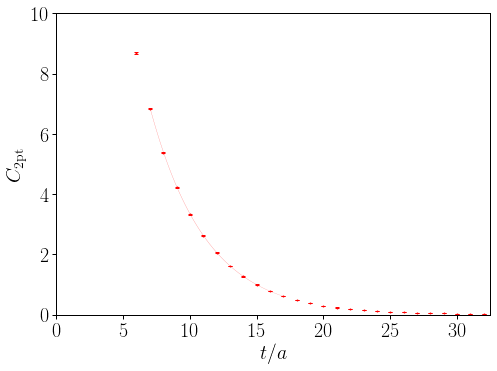

In [23]:
fit_x, fit_lower, fit_upper = get_fit_band(fit.p, fcn, xlims = (mpi_domain[0], mpi_domain[-1]))
plot_fit(C2_mu, C2_sigma, fit_x, fit_lower, fit_upper, '$C_{2\mathrm{pt}}$', ylims = (0, 10))

#### Fit $n_{levels}$ states

In [24]:
def make_prior(N):
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['Z'] = gv.gvar(N * ['40(40)'])
    prior['dE'] = gv.gvar(N * ['0.25(20)'])
    return prior

def fcn(t, p):
    """Exponential fitting function f(t) = \sum_i Z_i e^{- (\sum_{j=1}^i dE_j) t}."""
    Z = p['Z']        # array of Z's
    #print(Z)
    dE = p['dE']
    #print(dE)
    E = np.cumsum(dE)
    #return np.sum( Z * np.exp(-E * t) )
    result = 0.0
    for ii in range(len(E)):
        result += Z[ii] * np.exp(-E[ii] * t)
    return result

In [25]:
mpi_domain = np.arange(6, 18)    # domain to modify
# mpi_domain = np.arange(5, 18)    # domain to modify
t_dom, C2 = make_data(C2_folded, mpi_domain)
p0 = None 

for n_level in range(1, 5):
    print('----- n_level =', n_level, '-----')
    prior = make_prior(n_level)
    fit = lsqfit.nonlinear_fit(data = (t_dom, C2), fcn = fcn, prior = prior, p0 = p0)
    print(fit)                  # print the fit results
    
    Z = fit.p['Z']
    print(Z)
    dE = fit.p['dE']
    E = np.cumsum(dE)
    print(E)

----- n_level = 1 -----
Least Square Fit:
  chi2/dof [dof] = 6.5 [12]    Q = 9.8e-12    logGBF = 32.772

Parameters:
            Z 0     36.07 (11)      [    40 (40) ]  
           dE 0   0.23876 (37)      [  0.25 (20) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 8/0.0)
  fitter = scipy_least_squares    method = trf

[36.07(11)]
[0.23876(37)]
----- n_level = 2 -----
Least Square Fit:
  chi2/dof [dof] = 0.75 [12]    Q = 0.7    logGBF = 61.257

Parameters:
            Z 0     37.17 (20)      [    40 (40) ]  
              1     -2.20 (44)      [    40 (40) ]  *
           dE 0   0.24084 (49)      [  0.25 (20) ]  
              1     0.339 (73)      [  0.25 (20) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 9/0.0)
  fitter = scipy_least_squares    method = trf

[37.17(20) -2.20(44)]
[0.24084(49) 0.579(73)]
----- n_level = 3 -----
Least Square Fit:
  chi2/dof [dof] = 0.83 [12]    Q = 0.62    logGBF = 58.253

Parameter

## Fit 3-point functions

Plotting operator O1


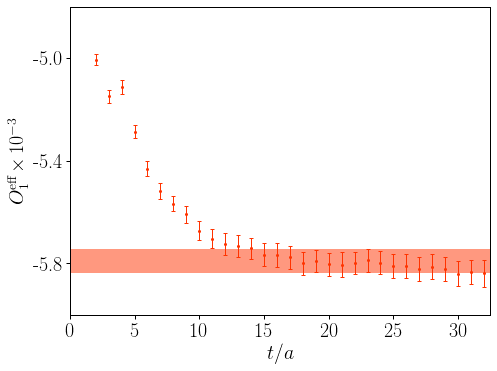

Plotting operator O2


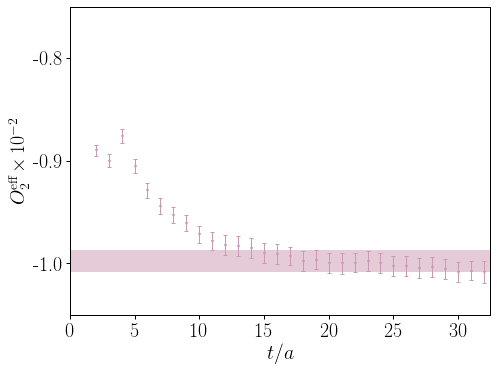

Plotting operator O3


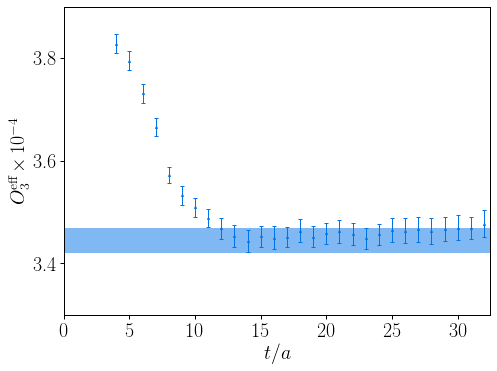

Plotting operator O1p


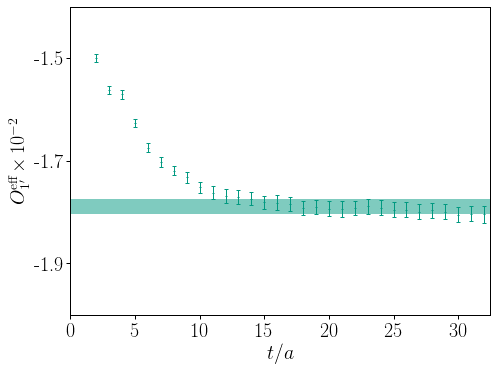

Plotting operator O2p


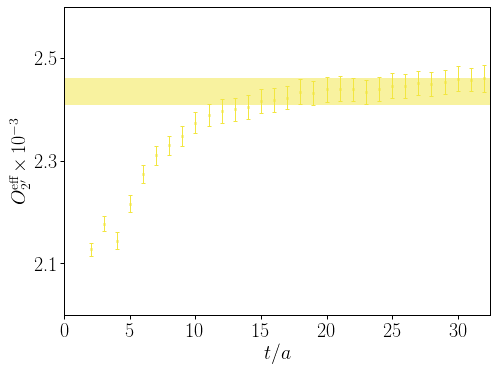

In [26]:
# plot 3-points
for i in range(n_ops):
    print('Plotting operator ' + str(op_labels[i]))
    fit_x, fit_lower, fit_upper = const_fit_band(c[i], sigmac[i])
    plot_fit(data_plot_mu[i], data_plot_sigma[i], fit_x, fit_lower, fit_upper, yaxis_labels[i], yrangep[i], \
             ytick_locs[i], ytick_labels[i], markers[i], colors[i])

In [27]:
def perform_fit(k, tmin, tmax, lam, c_priors, dE_prior):
    domain = np.arange(tmin, tmax)
    fit_data = data_slice[:, k, :]
    t_dom, Oeff = make_data(fit_data, domain, lam)
    prior = make_prior(c_priors, dE_prior)
    fit = lsqfit.nonlinear_fit(data = (t_dom, Oeff), fcn = fcn, prior = prior, p0 = p0)
    return fit

In [28]:
stab_formats = ['.', 'x', '+', 'v']
stab_colors = ['r', 'b', 'g', 'c']
def plot_stability(k, fit_dict, n_priors = 4, key_labels = ['tmin', 'tmax', 'lambda', 'prior'], saveat = None):
    n_keys = len(key_labels)
    legend_elems = [Line2D([0], [0], color = stab_colors[ii], lw = 4, label = key_labels[ii]) for ii in range(n_keys)]
    asp_ratio = 2.0
    fig_size = (style['colwidth'] * asp_ratio, style['colwidth'])
    Tmin_rg = tmin_rg_O3 if k == 2 else tmin_rg
    #intervals = np.cumsum([0, len(Tmin_rg), len(tmax_rg), len(lam_rg), n_priors])
    #doms = [np.arange(intervals[ii], intervals[ii + 1]) for ii in range(4)]
    start, doms = 0, []
    for key in key_labels:
        dint = len(fit_dict[k][key])
        doms.append(np.arange(start, start + dint))
        start += dint
    print(doms)
    with sns.plotting_context('paper'):
        all_labels = []
        all_doms = np.array([])
        plt.figure(figsize = fig_size)
        for ii, param_key in enumerate(key_labels):
            c0_dat = fit_data[k][param_key]
            if len(c0_dat) == 0:        # if this variation has no accepted fits
                continue
            print(c0_dat)
            labels = c0_dat.keys()
            cvs = [c0_dat[jj].p['c0'].mean for jj in labels]
            stds = [c0_dat[jj].p['c0'].sdev for jj in labels]
            _, caps, _ = plt.errorbar(doms[ii], cvs, yerr = stds, fmt = stab_formats[ii], c = stab_colors[ii], capsize = style['endcaps'], \
                         markersize = style['markersize'], elinewidth = style['ebar_width'])
            for cap in caps:
                cap.set_markeredgewidth(style['ecap_width'])
            plt.ylabel('c0', fontsize = style['fontsize'])
            all_doms = np.append(all_doms, doms[ii])
            all_labels.extend(labels)
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.set_xticks(all_doms)
        ax.set_xticklabels(all_labels)
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        ax.legend(handles = legend_elems, loc = 'upper left', bbox_to_anchor=(1.0, 1.0), prop={'size': 16})
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        plt.title('Fit stability for $' + latex_labels[k] + '$', fontsize = 16)
        plt.tight_layout()
        if saveat:
            plt.savefig(saveat, bbox_inches='tight')
        plt.show()

#### Constant fits to given range

In [29]:
const_domain = [
    [np.arange(17, 29), np.arange(17, 29), np.arange(17, 29), np.arange(17, 29), np.arange(17, 29)], 
#     [np.arange(12, 29), np.arange(12, 29), np.arange(12, 29), np.arange(12, 29), np.arange(12, 29)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)], 
    [np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1), np.arange(0, 1)]
][ens_idx]

In [30]:
# assemble data into correct form
def make_data(corr, domain, lam = 1):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T). Here lam is the shrinkage parameter λ, which is 
    set to 1 (fully correlated) by default. 
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    full_cov = np.array(df.cov())
    cov = shrinkage(full_cov, lam)    # try shrinkage
    #cov = np.array(df.cov())
    return domain, gv.gvar(mean, cov)

def make_prior():
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['c'] = gv.gvar(0.0, 0.1)
    return prior

def fcn(t, p):
    """Constant fitting function f(t; c) = c."""
    c = p['c']
    return c + 0*t

In [31]:
# Fit data_slice[b, k, t]. Note that I think there's a lot of correlation, and so the fits don't look great 
# because gv.evalcov(Oeff) is the same order of magnitude everywhere. Not sure why svdcut isn't doing anything.
fit_outs = []
ops = []
λ = 0.5
for k in range(n_ops):
    domain = const_domain[k]
    fit_data = data_slice[:, k, :]
    t_dom, Oeff = make_data(fit_data, domain, lam = λ)
    ops.append(Oeff)
    print(t_dom)
    print(Oeff)
    prior = make_prior()
    p0 = None
    fit = lsqfit.nonlinear_fit(data = (t_dom, Oeff), fcn = fcn, prior = prior, p0 = p0, svdcut = 1e-10)
    print(fit)
    fit_outs.append(fit)

[17 18 19 20 21 22 23 24 25 26 27 28]
[-0.005777(44) -0.005800(46) -0.005791(44) -0.005805(45) -0.005805(48)
 -0.005799(44) -0.005789(46) -0.005797(44) -0.005811(45) -0.005810(48)
 -0.005822(47) -0.005814(49)]
Least Square Fit:
  chi2/dof [dof] = 0.11 [12]    Q = 1    logGBF = 102.73

Parameters:
              c   -0.005798 (32)       [  0.00 (10) ]  

Settings:
  svdcut/n = 1e-10/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 4/0.0)
  fitter = scipy_least_squares    method = trf

[17 18 19 20 21 22 23 24 25 26 27 28]
[-0.009927(90) -0.009974(97) -0.009965(94) -0.009994(99) -0.01000(10)
 -0.009994(95) -0.009975(97) -0.009998(94) -0.010025(97) -0.010025(96)
 -0.010048(96) -0.010038(98)]
Least Square Fit:
  chi2/dof [dof] = 0.19 [12]    Q = 1    logGBF = 94.126

Parameters:
              c   -0.009991 (69)       [  0.00 (10) ]  

Settings:
  svdcut/n = 1e-10/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 4/0.0)
  fitter = scipy_least_squares    method = trf

[17 18 19 20 21 22 23 24 25

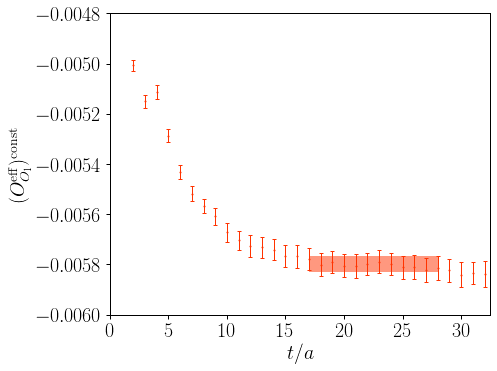

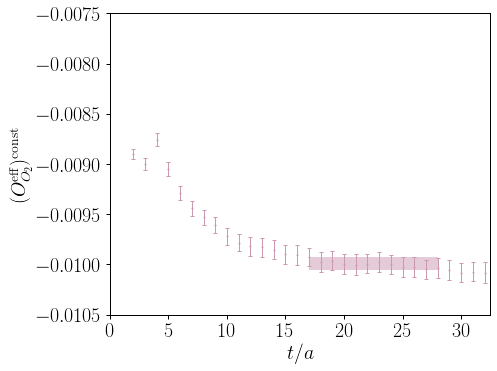

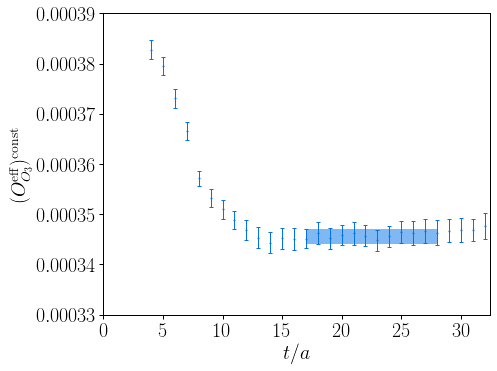

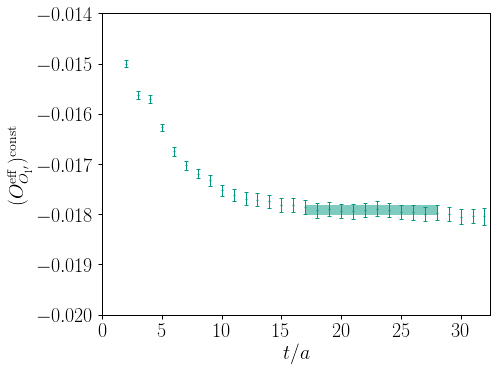

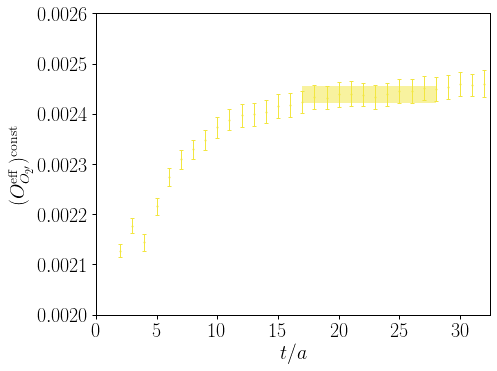

In [32]:
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (const_domain[k][0], const_domain[k][-1]))
    plot_fit(data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, '$(O_{' + latex_labels[k] \
             + '}^{\mathrm{eff}})^{\mathrm{const}}$', ylims = yrangep[k], col = colors[k])

In [33]:
# check out covariance of O2p
for k in range(n_ops):
    u, s, v = np.linalg.svd(gv.evalcov(ops[k]))
    print(s)

[1.28493853e-08 1.50997364e-09 1.23499891e-09 1.18735894e-09
 1.14148608e-09 1.10691520e-09 1.09658203e-09 1.06526489e-09
 1.01757626e-09 1.00888346e-09 1.00364145e-09 9.80228874e-10]
[5.74077440e-08 6.34194968e-09 5.24191592e-09 4.99018738e-09
 4.94634608e-09 4.87508207e-09 4.79243557e-09 4.70788555e-09
 4.66540330e-09 4.55322016e-09 4.54220575e-09 4.27761741e-09]
[2.85600504e-11 4.32299571e-12 3.28340024e-12 3.00135325e-12
 2.90819062e-12 2.79683554e-12 2.55930250e-12 2.37773381e-12
 2.36435820e-12 2.27367195e-12 2.15481637e-12 2.01745193e-12]
[1.25951920e-07 1.48169929e-08 1.20248716e-08 1.16476801e-08
 1.11323243e-08 1.08376254e-08 1.07124816e-08 1.04509304e-08
 9.98653169e-09 9.95703517e-09 9.83043845e-09 9.61676570e-09]
[3.41619701e-09 3.79864898e-10 3.13424643e-10 2.97202170e-10
 2.96395128e-10 2.89489520e-10 2.84782389e-10 2.79679798e-10
 2.76634467e-10 2.71081633e-10 2.69092838e-10 2.56304126e-10]


#### Excited state fit (single exponential)

In [34]:
exc_domain = [
    [np.arange(5, 33), np.arange(5, 33), np.arange(7, 33), np.arange(5, 33), np.arange(5, 33)], 
    [np.arange(5, 33), np.arange(5, 33), np.arange(7, 33), np.arange(5, 33), np.arange(5, 33)], 
    [np.arange(5, 33), np.arange(5, 33), np.arange(7, 33), np.arange(5, 33), np.arange(5, 33)], 
    [np.arange(5, 33), np.arange(5, 33), np.arange(7, 33), np.arange(5, 33), np.arange(5, 33)], 
    [np.arange(5, 33), np.arange(5, 33), np.arange(7, 33), np.arange(5, 33), np.arange(5, 33)]
#     [np.arange(6, 33), np.arange(6, 33), np.arange(8, 33), np.arange(6, 33), np.arange(6, 33)]
][ens_idx]

In [35]:
# assemble data into correct form
def make_data(corr, domain, lam = 1):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T). Here lam is the shrinkage parameter λ, which is 
    set to 1 (fully correlated) by default. 
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    full_cov = np.array(df.cov())
    cov = shrinkage(full_cov, lam)    # try shrinkage
    #cov = np.array(df.cov())
    return domain, gv.gvar(mean, cov)

def make_prior(c_widths = [0.1, 0.1], dE_width = 0.4):
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['c0'] = gv.gvar(0.0, c_widths[0])
    prior['c1'] = gv.gvar(0.0, c_widths[1])
    prior['log(dE)'] = np.log(gv.gvar(0.1, dE_width))
    return prior

def fcn(t, p):
    """Single exponential fitting function."""
    c0 = p['c0']
    c1 = p['c1']
    dE = p['dE']
    return c0 + c1 * np.exp(-dE*t)

In [36]:
# Fit data_slice[b, k, t]. 
fit_outs = []
fit_chi2_dof = []
Oeff_cv = []
Oeff_std = []
λ = 0.9
# λ = 0.5
# λ = 0.75
for k in range(n_ops):
    print('Fitting ' + op_labels[k])
    domain = exc_domain[k]
    fit_data = data_slice[:, k, :]
    t_dom, Oeff = make_data(fit_data, domain, λ)
    prior = make_prior()
    p0 = None
    fit = lsqfit.nonlinear_fit(data = (t_dom, Oeff), fcn = fcn, prior = prior, p0 = p0)
    
    # print fit and save parameters
    print(fit)
    fit_outs.append(fit)
    fit_chi2_dof.append(fit.chi2 / fit.dof)
    Oeff_cv.append(fit.p['c0'].mean)
    Oeff_std.append(fit.p['c0'].sdev)
Oeff_cv = np.array(Oeff_cv)
Oeff_std = np.array(Oeff_std)

Fitting O1
Least Square Fit:
  chi2/dof [dof] = 0.61 [28]    Q = 0.95    logGBF = 252.13

Parameters:
             c0   -0.005802 (39)       [  0.00 (10) ]  
             c1     0.00191 (15)       [  0.00 (10) ]  
        log(dE)      -1.332 (71)       [ -2.3 (4.0) ]  
-----------------------------------------------------
             dE       0.264 (19)       [  0.10 (40) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 9/0.0)
  fitter = scipy_least_squares    method = trf

Fitting O2
Least Square Fit:
  chi2/dof [dof] = 0.39 [28]    Q = 1    logGBF = 235.86

Parameters:
             c0   -0.010040 (84)       [  0.00 (10) ]  
             c1     0.00297 (26)       [  0.00 (10) ]  
        log(dE)      -1.495 (86)       [ -2.3 (4.0) ]  
-----------------------------------------------------
             dE       0.224 (19)       [  0.10 (40) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 9/0.0)
  fitter = scipy_least_sq

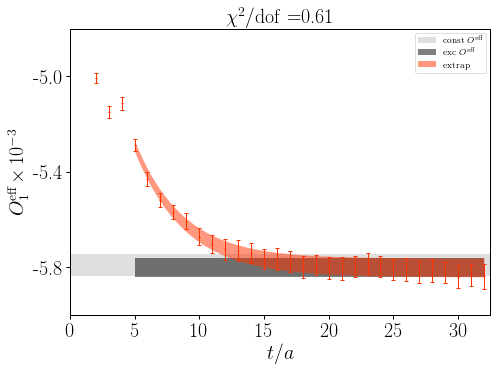

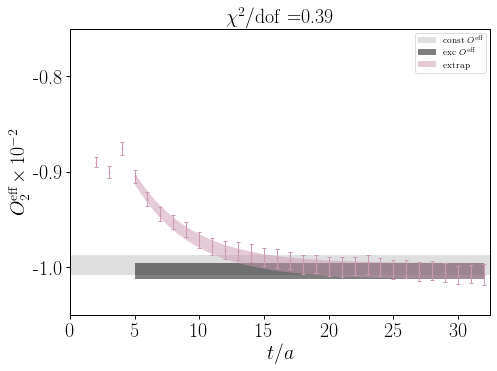

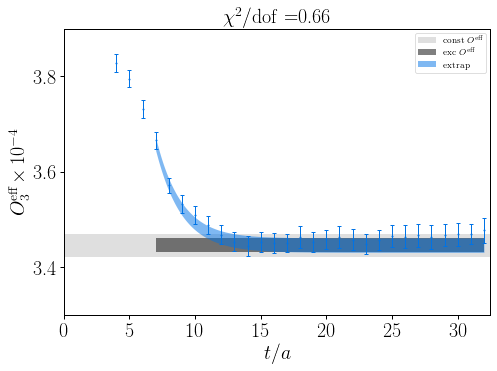

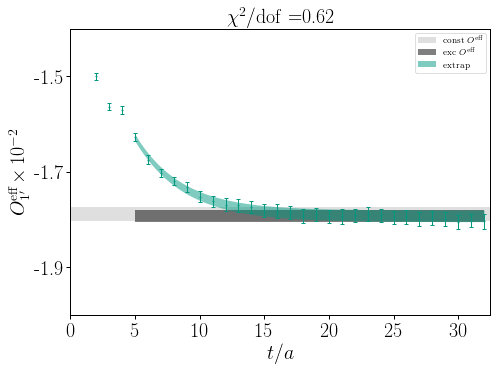

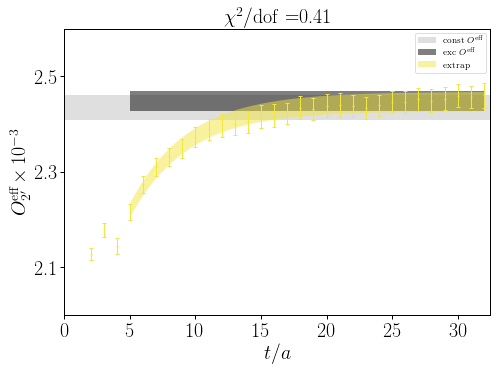

In [37]:
style = styles['notebook']
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (exc_domain[k][0], exc_domain[k][-1]))
    O_mu, O_std = fit_outs[k].p['c0'].mean, fit_outs[k].p['c0'].sdev
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/single_exp/comparisons/' + ens_path \
            + '/' + op_labels[k] + '.pdf'
    plot_fit(data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, yaxis_labels[k], ylims = yrangep[k], \
             yt_locs = ytick_locs[k], yt_labels = ytick_labels[k], col = colors[k], Oeff_mu = Oeff_cv[k], Oeff_sigma \
             = Oeff_std[k], const_mu = c[k], const_sigma = sigmac[k], chi2_dof = fit_chi2_dof[k], saveat = path)

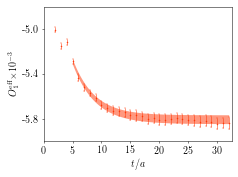

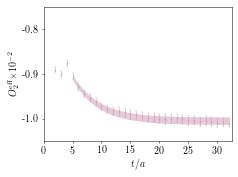

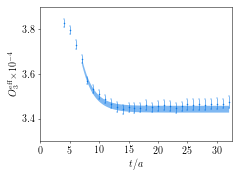

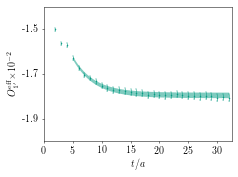

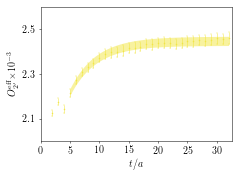

In [38]:
style = styles['prd_twocol']
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (exc_domain[k][0], exc_domain[k][-1]))
    #path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems_single_exp/' + ens_path + \
    #        '/' + op_labels[k] + '.pdf'
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/single_exp/' + ens_path + \
            '/' + op_labels[k] + '.pdf'
    plot_fit(data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, yaxis_labels[k], ylims = yrangep[k], \
             yt_locs = ytick_locs[k], yt_labels = ytick_labels[k], col = colors[k], saveat = path)

In [39]:
tmin0, tmin_rg = 5, [4, 5, 6, 7, 8]
tmin0_O3, tmin_rg_O3 = 8, [8, 9, 10, 11]        # O3 has more excited state contamination
tmax0, tmax_rg = 33, [30, 31, 32, 33]
# tmax0, tmax_rg = 32, [30, 31, 32, 33]
lam0, lam_rg = 0.9, np.arange(0.75, 1.0, 0.05)
ll_strs = ['0.75', '0.8', '0.85', '0.9', '0.95']
c_width = [0.1, 0.1]
dE_width = 0.4
n_priors = 4
key_labels = ['tmin', 'tmax', 'lambda', 'prior']
n_keys = len(key_labels)

In [40]:
# vary t_{min} and see how the posterior for the extracted matrix element reacts
fit_data = [{'tmin' : {}, 'tmax' : {}, 'lambda' : {}, 'prior' : {}} for k in range(n_ops)]
p0 = None
for k in range(n_ops):
    print('Stability with single-exp for O' + str(k))
    Tmin0 = tmin0_O3 if k == 2 else tmin0
    Tmin_rg = tmin_rg_O3 if k == 2 else tmin_rg
    for tm in Tmin_rg:
        fit_data[k]['tmin'][str(tm)] = perform_fit(k, tm, tmax0, lam0, c_width, dE_width)
    for tp in tmax_rg:
        fit_data[k]['tmax'][str(tp)] = perform_fit(k, Tmin0, tp, lam0, c_width, dE_width)
    for il, ll in enumerate(lam_rg):
        ll_key = ll_strs[il]
        fit_data[k]['lambda'][ll_key] = perform_fit(k, Tmin0, tmax0, ll, c_width, dE_width)
    fit_data[k]['prior']['c0'] = perform_fit(k, Tmin0, tmax0, lam0, [10*c_width[0],c_width[1]], dE_width)
    fit_data[k]['prior']['c1'] = perform_fit(k, Tmin0, tmax0, lam0, [c_width[0],10*c_width[1]], dE_width)
    fit_data[k]['prior']['dE'] = perform_fit(k, Tmin0, tmax0, lam0, [c_width[0],c_width[1]], 10*dE_width)

Stability with single-exp for O0
Stability with single-exp for O1
Stability with single-exp for O2
Stability with single-exp for O3
Stability with single-exp for O4


[array([0, 1, 2, 3, 4]), array([5, 6, 7, 8]), array([ 9, 10, 11, 12, 13]), array([14, 15, 16])]
{'4': <lsqfit.nonlinear_fit object at 0x141780d90>, '5': <lsqfit.nonlinear_fit object at 0x1404df9d0>, '6': <lsqfit.nonlinear_fit object at 0x1416c2050>, '7': <lsqfit.nonlinear_fit object at 0x1417b1780>, '8': <lsqfit.nonlinear_fit object at 0x1417b1390>}
{'30': <lsqfit.nonlinear_fit object at 0x1417b2c20>, '31': <lsqfit.nonlinear_fit object at 0x1417b34c0>, '32': <lsqfit.nonlinear_fit object at 0x1417cd810>, '33': <lsqfit.nonlinear_fit object at 0x1417ce020>}
{'0.75': <lsqfit.nonlinear_fit object at 0x1417cfd30>, '0.8': <lsqfit.nonlinear_fit object at 0x1417cfeb0>, '0.85': <lsqfit.nonlinear_fit object at 0x1417e9c60>, '0.9': <lsqfit.nonlinear_fit object at 0x1417eb100>, '0.95': <lsqfit.nonlinear_fit object at 0x1417eb310>}
{'c0': <lsqfit.nonlinear_fit object at 0x1417f85e0>, 'c1': <lsqfit.nonlinear_fit object at 0x1417fa680>, 'dE': <lsqfit.nonlinear_fit object at 0x1417fada0>}


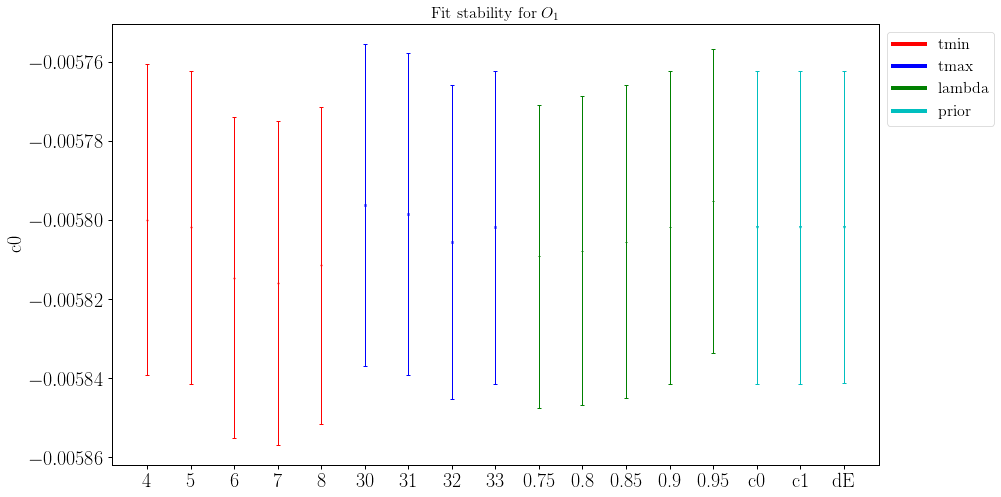

[array([0, 1, 2, 3, 4]), array([5, 6, 7, 8]), array([ 9, 10, 11, 12, 13]), array([14, 15, 16])]
{'4': <lsqfit.nonlinear_fit object at 0x1417fb7c0>, '5': <lsqfit.nonlinear_fit object at 0x141815090>, '6': <lsqfit.nonlinear_fit object at 0x141816c50>, '7': <lsqfit.nonlinear_fit object at 0x141817d30>, '8': <lsqfit.nonlinear_fit object at 0x141817e80>}
{'30': <lsqfit.nonlinear_fit object at 0x14182db70>, '31': <lsqfit.nonlinear_fit object at 0x14182e2f0>, '32': <lsqfit.nonlinear_fit object at 0x14182fdc0>, '33': <lsqfit.nonlinear_fit object at 0x14182e260>}
{'0.75': <lsqfit.nonlinear_fit object at 0x141856320>, '0.8': <lsqfit.nonlinear_fit object at 0x1418574f0>, '0.85': <lsqfit.nonlinear_fit object at 0x141857670>, '0.9': <lsqfit.nonlinear_fit object at 0x14186d900>, '0.95': <lsqfit.nonlinear_fit object at 0x14186e8c0>}
{'c0': <lsqfit.nonlinear_fit object at 0x14186f880>, 'c1': <lsqfit.nonlinear_fit object at 0x14186f8b0>, 'dE': <lsqfit.nonlinear_fit object at 0x14188de70>}


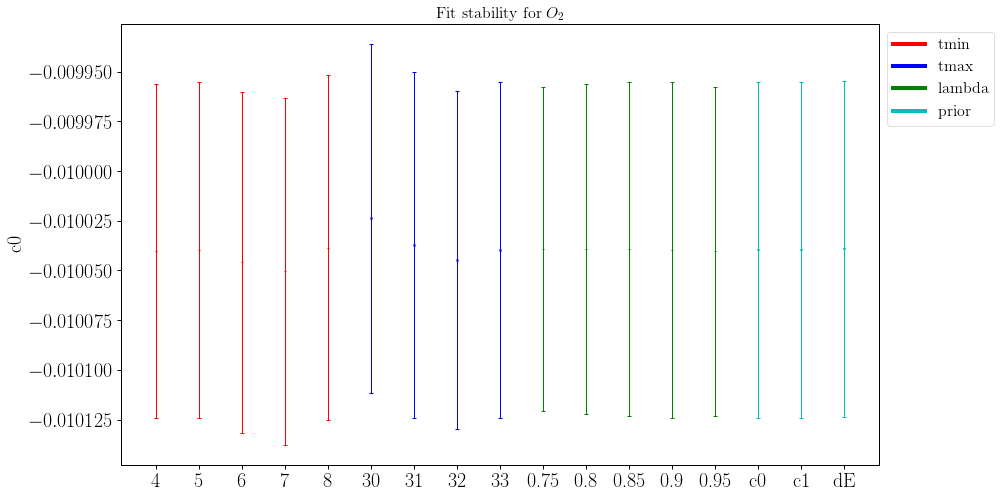

[array([0, 1, 2, 3]), array([4, 5, 6, 7]), array([ 8,  9, 10, 11, 12]), array([13, 14, 15])]
{'8': <lsqfit.nonlinear_fit object at 0x14188e680>, '9': <lsqfit.nonlinear_fit object at 0x14188e2f0>, '10': <lsqfit.nonlinear_fit object at 0x14188f460>, '11': <lsqfit.nonlinear_fit object at 0x1418a58a0>}
{'30': <lsqfit.nonlinear_fit object at 0x1418a6680>, '31': <lsqfit.nonlinear_fit object at 0x1418a7610>, '32': <lsqfit.nonlinear_fit object at 0x1418a6e60>, '33': <lsqfit.nonlinear_fit object at 0x1418bd1e0>}
{'0.75': <lsqfit.nonlinear_fit object at 0x1418bdde0>, '0.8': <lsqfit.nonlinear_fit object at 0x1418bfa60>, '0.85': <lsqfit.nonlinear_fit object at 0x1418be4d0>, '0.9': <lsqfit.nonlinear_fit object at 0x1418e0e50>, '0.95': <lsqfit.nonlinear_fit object at 0x1418e1f00>}
{'c0': <lsqfit.nonlinear_fit object at 0x1418e3bb0>, 'c1': <lsqfit.nonlinear_fit object at 0x1418f8640>, 'dE': <lsqfit.nonlinear_fit object at 0x1418f91b0>}


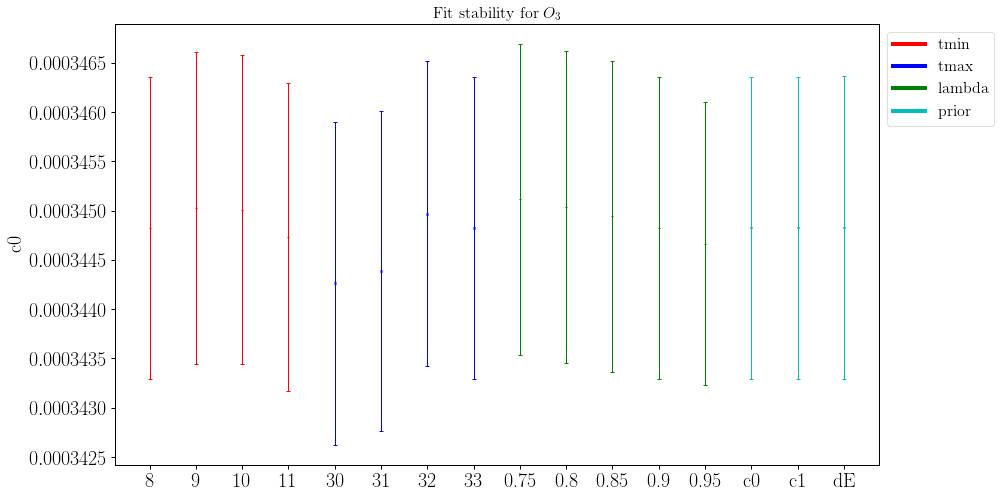

[array([0, 1, 2, 3, 4]), array([5, 6, 7, 8]), array([ 9, 10, 11, 12, 13]), array([14, 15, 16])]
{'4': <lsqfit.nonlinear_fit object at 0x1418fa9e0>, '5': <lsqfit.nonlinear_fit object at 0x1418fae00>, '6': <lsqfit.nonlinear_fit object at 0x141914b20>, '7': <lsqfit.nonlinear_fit object at 0x1419167a0>, '8': <lsqfit.nonlinear_fit object at 0x1419163b0>}
{'30': <lsqfit.nonlinear_fit object at 0x141914280>, '31': <lsqfit.nonlinear_fit object at 0x14192d660>, '32': <lsqfit.nonlinear_fit object at 0x14192d510>, '33': <lsqfit.nonlinear_fit object at 0x14192fa90>}
{'0.75': <lsqfit.nonlinear_fit object at 0x14192fca0>, '0.8': <lsqfit.nonlinear_fit object at 0x141949f00>, '0.85': <lsqfit.nonlinear_fit object at 0x14194b0d0>, '0.9': <lsqfit.nonlinear_fit object at 0x14194b1c0>, '0.95': <lsqfit.nonlinear_fit object at 0x14194b7c0>}
{'c0': <lsqfit.nonlinear_fit object at 0x1419618d0>, 'c1': <lsqfit.nonlinear_fit object at 0x141963610>, 'dE': <lsqfit.nonlinear_fit object at 0x1419627a0>}


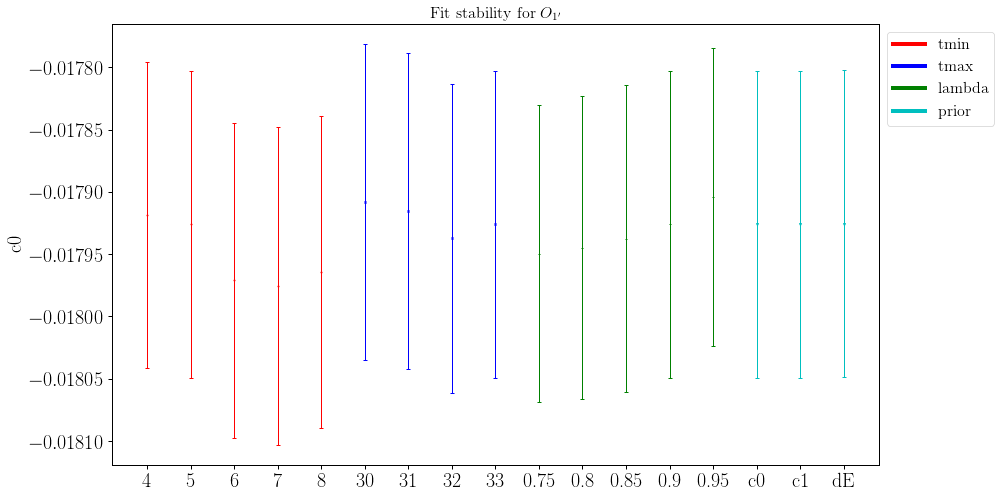

[array([0, 1, 2, 3, 4]), array([5, 6, 7, 8]), array([ 9, 10, 11, 12, 13]), array([14, 15, 16])]
{'4': <lsqfit.nonlinear_fit object at 0x1419790c0>, '5': <lsqfit.nonlinear_fit object at 0x14197a950>, '6': <lsqfit.nonlinear_fit object at 0x14197afe0>, '7': <lsqfit.nonlinear_fit object at 0x14197bbb0>, '8': <lsqfit.nonlinear_fit object at 0x1419a1b10>}
{'30': <lsqfit.nonlinear_fit object at 0x1419a2950>, '31': <lsqfit.nonlinear_fit object at 0x1419a3190>, '32': <lsqfit.nonlinear_fit object at 0x1419a3f10>, '33': <lsqfit.nonlinear_fit object at 0x1419b95d0>}
{'0.75': <lsqfit.nonlinear_fit object at 0x1419ba5f0>, '0.8': <lsqfit.nonlinear_fit object at 0x1419bb3a0>, '0.85': <lsqfit.nonlinear_fit object at 0x1419d8640>, '0.9': <lsqfit.nonlinear_fit object at 0x1419d9bd0>, '0.95': <lsqfit.nonlinear_fit object at 0x1419dada0>}
{'c0': <lsqfit.nonlinear_fit object at 0x1419da860>, 'c1': <lsqfit.nonlinear_fit object at 0x1419ed000>, 'dE': <lsqfit.nonlinear_fit object at 0x1419ee0e0>}


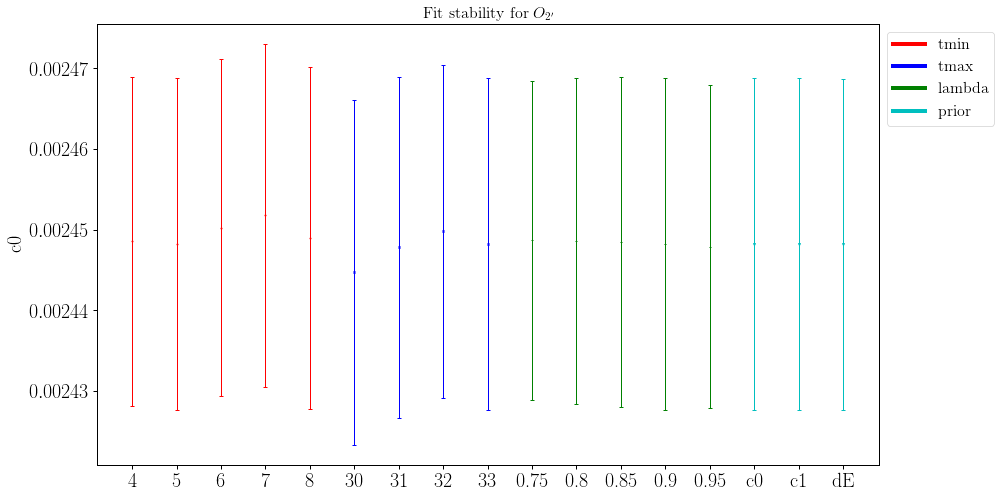

In [41]:
style = styles['notebook']
for k in range(n_ops):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/single_exp/stability/' + ens_path \
            + '/' + op_labels[k] + '.pdf'
    plot_stability(k, fit_data, n_priors = 3, saveat = path)

In [42]:
fits = np.array([gen_fake_ensemble([Oeff_cv[k], Oeff_std[k]]) for k in range(n_ops)])
out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + ensemble + '/fit_params_exc.h5'
fout = h5py.File(out_file, 'w')
fout['fits'] = fits.T
fout['data_slice'] = data_slice
fout['c'] = np.array(Oeff_cv)
fout['sigmac'] = np.array(Oeff_std)
fout['plot_domain'] = plot_domain
for k in range(n_ops):
    fout['fit_domain/' + str(op_labels[k])] = np.array(exc_domain[k], dtype = np.float64)
fout.close()
print('Results output to: ' + out_file)

Results output to: /Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/24I/ml_0p01/fit_params_exc.h5


#### Excited state fit (single exponential + backpropagating)

Note: The backpropagating fit seems to describe the shape of the R-ratio very precisely, and ends up with a fit band that lies basically on top of the data at its fullest extent. However, I'm not sure if it's overfitting or not.

In [43]:
exc_domain = [
    [np.arange(5, 33), np.arange(5, 33), np.arange(8, 33), np.arange(5, 33), np.arange(5, 33)], 
    [np.arange(5, 33), np.arange(5, 33), np.arange(8, 33), np.arange(5, 33), np.arange(5, 33)], 
    [np.arange(5, 33), np.arange(5, 33), np.arange(8, 33), np.arange(5, 33), np.arange(5, 33)], 
    [np.arange(5, 33), np.arange(5, 33), np.arange(8, 33), np.arange(5, 33), np.arange(5, 33)], 
#     [np.arange(6, 33), np.arange(6, 33), np.arange(8, 33), np.arange(6, 33), np.arange(6, 33)], 
#     [np.arange(4, 33), np.arange(4, 33), np.arange(7, 33), np.arange(4, 33), np.arange(4, 33)]
    [np.arange(5, 33), np.arange(5, 33), np.arange(9, 33), np.arange(5, 33), np.arange(5, 33)]
#     [np.arange(6, 33), np.arange(6, 33), np.arange(9, 33), np.arange(6, 33), np.arange(6, 33)]
#     [np.arange(8, 31), np.arange(8, 31), np.arange(9, 33), np.arange(8, 31), np.arange(8, 31)]
][ens_idx]

In [44]:
# assemble data into correct form
def make_data(corr, domain, lam = 1):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T). Here lam is the shrinkage parameter λ, which is 
    set to 1 (fully correlated) by default. 
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    full_cov = np.array(df.cov())
    cov = shrinkage(full_cov, lam)    # try shrinkage
    #cov = np.array(df.cov())
    return domain, gv.gvar(mean, cov)

def make_prior(c_widths = [0.1, 0.1, 0.1], dE_width = 0.4):
    """
    Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
    Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
    """
    prior = gv.BufferDict()
    prior['c0'] = gv.gvar(0.0, c_widths[0])
    prior['c1'] = gv.gvar(0.0, c_widths[1])
    prior['c2'] = gv.gvar(0.0, c_widths[2])
    prior['log(dE)'] = np.log(gv.gvar(0.1, dE_width))
    return prior
def fcn(t, p):
    """Single exponential fitting function + backpropagating state."""
    c0 = p['c0']
    c1 = p['c1']
    c2 = p['c2']
    dE = p['dE']
    return c0 + c1 * np.exp(-dE*t) + c2 * np.exp(-dE*(T - t))

In [45]:
# Fit data_slice[b, k, t]. 
fit_outs = []
fit_chi2_dof = []
Oeff_cv = []
Oeff_std = []
# λ = 0.95
λ = 0.9
# λ = 0.75
for k in range(n_ops):
    print('Fitting ' + op_labels[k])
    domain = exc_domain[k]
    fit_data = data_slice[:, k, :]
    t_dom, Oeff = make_data(fit_data, domain, λ)
    prior = make_prior()
    p0 = None
    fit = lsqfit.nonlinear_fit(data = (t_dom, Oeff), fcn = fcn, prior = prior, p0 = p0)
    
    # print fit and save parameters
    print(fit)
    fit_outs.append(fit)
    fit_chi2_dof.append(fit.chi2 / fit.dof)
    Oeff_cv.append(fit.p['c0'].mean)
    Oeff_std.append(fit.p['c0'].sdev)
Oeff_cv = np.array(Oeff_cv)
Oeff_std = np.array(Oeff_std)

Fitting O1
Least Square Fit:
  chi2/dof [dof] = 0.54 [28]    Q = 0.98    logGBF = 252.61

Parameters:
             c0   -0.005809 (38)       [  0.00 (10) ]  
             c1     0.00184 (13)       [  0.00 (10) ]  
             c2      -0.104 (78)       [  0.00 (10) ]  *
        log(dE)      -1.365 (62)       [ -2.3 (4.0) ]  
-----------------------------------------------------
             dE       0.255 (16)       [  0.10 (40) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 16/0.0)
  fitter = scipy_least_squares    method = trf

Fitting O2
Least Square Fit:
  chi2/dof [dof] = 0.33 [28]    Q = 1    logGBF = 236.07

Parameters:
             c0   -0.010023 (84)       [  0.00 (10) ]  
             c1     0.00289 (24)       [  0.00 (10) ]  
             c2      -0.078 (71)       [  0.00 (10) ]  
        log(dE)      -1.506 (78)       [ -2.3 (4.0) ]  
-----------------------------------------------------
             dE       0.222 (17)       [  0.10 (40) 

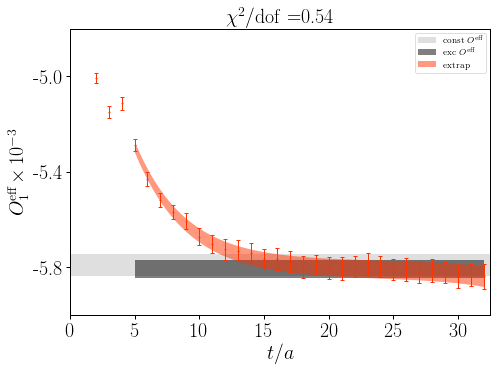

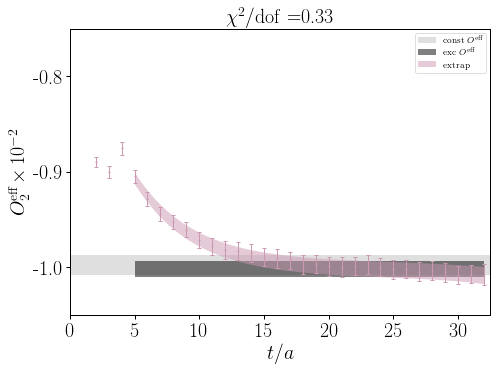

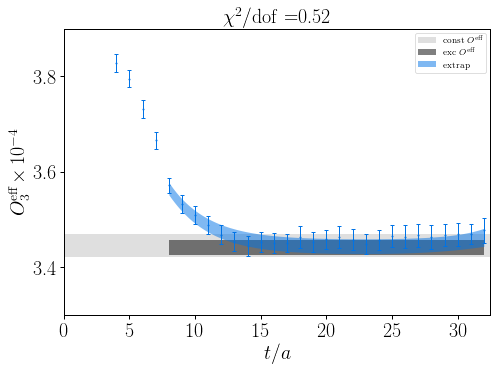

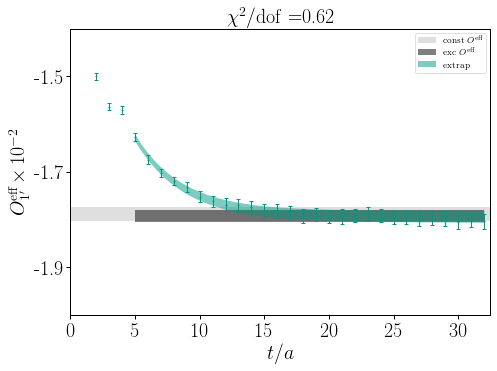

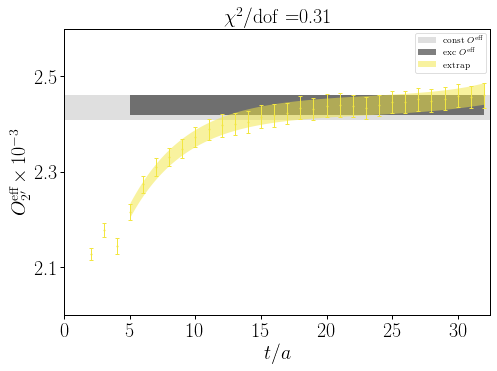

In [46]:
style = styles['notebook']
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (exc_domain[k][0], exc_domain[k][-1]))
    O_mu, O_std = fit_outs[k].p['c0'].mean, fit_outs[k].p['c0'].sdev
    #path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems_backprop/comparisons/' + ens_path \
    #        + '/' + op_labels[k] + '.pdf'
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/backprop/comparisons/' + ens_path \
            + '/' + op_labels[k] + '.pdf'
    plot_fit(data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, yaxis_labels[k], ylims = yrangep[k], \
             yt_locs = ytick_locs[k], yt_labels = ytick_labels[k], col = colors[k], Oeff_mu = Oeff_cv[k], Oeff_sigma \
             = Oeff_std[k], const_mu = c[k], const_sigma = sigmac[k], chi2_dof = fit_chi2_dof[k], saveat = path)

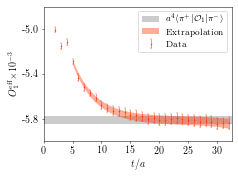

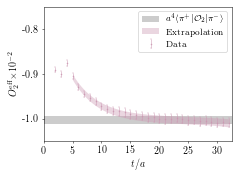

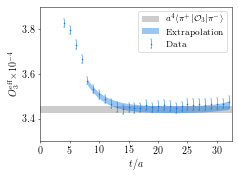

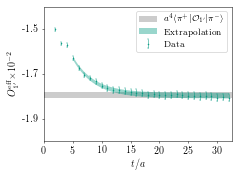

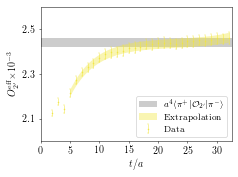

In [47]:
# results from a single fit window
style = styles['prd_twocol']
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (exc_domain[k][0], exc_domain[k][-1]))
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/backprop/' + ens_path + \
            '/' + op_labels[k] + '.pdf'
    plot_fit_paper(k, data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, yaxis_labels[k], ylims = \
                   yrangep[k], yt_locs = ytick_locs[k], yt_labels = ytick_labels[k], col = colors[k], saveat = path, \
                   Oeff_mu = Oeff_cv[k], Oeff_sigma = Oeff_std[k])

#### Stability plots

In [48]:
# tmin0, tmin_rg = 5, [4, 5, 6, 7, 8]
tmin0, tmin_rg = 5, [5, 6, 7, 8]
# tmin0_O3, tmin_rg_O3 = 8, [8, 9, 10, 11]        # O3 has more excited state contamination
tmin0_O3, tmin_rg_O3 = 9, [8, 9, 10]
tmax0, tmax_rg = 33, [30, 31, 32, 33]
# tmax0, tmax_rg = 32, [30, 31, 32, 33]
lam0, lam_rg = 0.9, np.arange(0.75, 1.0, 0.05)
ll_strs = ['0.75', '0.8', '0.85', '0.9', '0.95']
c_width = [0.1, 0.1, 0.1]
dE_width = 0.4
n_priors = 4
key_labels = ['tmin', 'tmax', 'lambda', 'prior']
n_keys = len(key_labels)

In [49]:
# vary t_{min} and see how the posterior for the extracted matrix element reacts
fit_data = [{'tmin' : {}, 'tmax' : {}, 'lambda' : {}, 'prior' : {}} for k in range(n_ops)]
p0 = None
for k in range(n_ops):
    print('Stability with single-exp + backpropr for O' + str(k))
    Tmin0 = tmin0_O3 if k == 2 else tmin0
    Tmin_rg = tmin_rg_O3 if k == 2 else tmin_rg
    for tm in Tmin_rg:
        fit_data[k]['tmin'][str(tm)] = perform_fit(k, tm, tmax0, lam0, c_width, dE_width)
    for tp in tmax_rg:
        fit_data[k]['tmax'][str(tp)] = perform_fit(k, Tmin0, tp, lam0, c_width, dE_width)
    for il, ll in enumerate(lam_rg):
        ll_key = ll_strs[il]
        fit_data[k]['lambda'][ll_key] = perform_fit(k, Tmin0, tmax0, ll, c_width, dE_width)
    fit_data[k]['prior']['c0'] = perform_fit(k, Tmin0, tmax0, lam0, [10*c_width[0],c_width[1],c_width[2]], dE_width)
    fit_data[k]['prior']['c1'] = perform_fit(k, Tmin0, tmax0, lam0, [c_width[0],10*c_width[1],c_width[2]], dE_width)
    fit_data[k]['prior']['c2'] = perform_fit(k, Tmin0, tmax0, lam0, [c_width[0],c_width[1],10*c_width[2]], dE_width)
    fit_data[k]['prior']['dE'] = perform_fit(k, Tmin0, tmax0, lam0, [c_width[0],c_width[1],c_width[2]], 10*dE_width)

Stability with single-exp + backpropr for O0
Stability with single-exp + backpropr for O1
Stability with single-exp + backpropr for O2
Stability with single-exp + backpropr for O3
Stability with single-exp + backpropr for O4


[array([0, 1, 2, 3]), array([4, 5, 6, 7]), array([ 8,  9, 10, 11, 12]), array([13, 14, 15, 16])]
{'5': <lsqfit.nonlinear_fit object at 0x140642a70>, '6': <lsqfit.nonlinear_fit object at 0x1405577c0>, '7': <lsqfit.nonlinear_fit object at 0x1404dfd90>, '8': <lsqfit.nonlinear_fit object at 0x1404debf0>}
{'30': <lsqfit.nonlinear_fit object at 0x1404df940>, '31': <lsqfit.nonlinear_fit object at 0x1404dc070>, '32': <lsqfit.nonlinear_fit object at 0x1404e96c0>, '33': <lsqfit.nonlinear_fit object at 0x1404e8040>}
{'0.75': <lsqfit.nonlinear_fit object at 0x1404e85b0>, '0.8': <lsqfit.nonlinear_fit object at 0x1404a8970>, '0.85': <lsqfit.nonlinear_fit object at 0x1404a92d0>, '0.9': <lsqfit.nonlinear_fit object at 0x1404aa6e0>, '0.95': <lsqfit.nonlinear_fit object at 0x14047a200>}
{'c0': <lsqfit.nonlinear_fit object at 0x14047aad0>, 'c1': <lsqfit.nonlinear_fit object at 0x14047bc40>, 'c2': <lsqfit.nonlinear_fit object at 0x14047b1f0>, 'dE': <lsqfit.nonlinear_fit object at 0x140443160>}


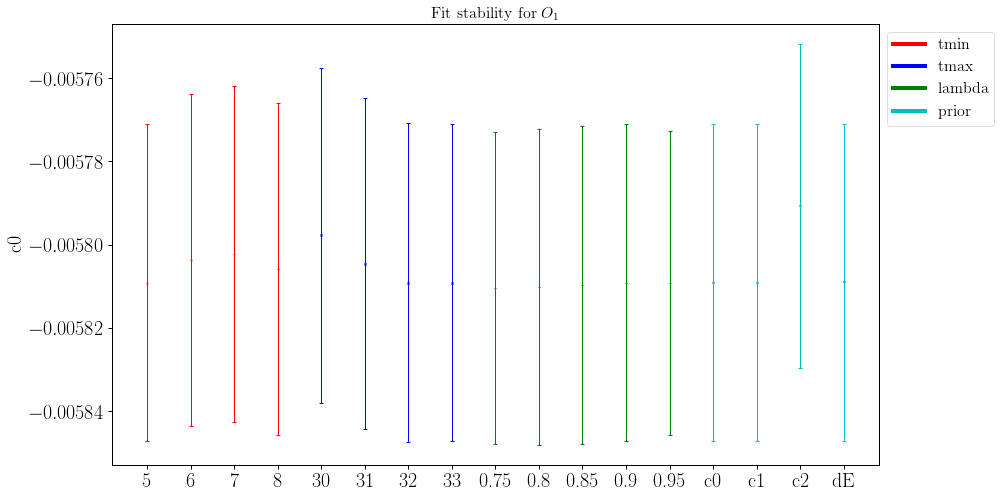

[array([0, 1, 2, 3]), array([4, 5, 6, 7]), array([ 8,  9, 10, 11, 12]), array([13, 14, 15, 16])]
{'5': <lsqfit.nonlinear_fit object at 0x1404437f0>, '6': <lsqfit.nonlinear_fit object at 0x140440d30>, '7': <lsqfit.nonlinear_fit object at 0x1404628c0>, '8': <lsqfit.nonlinear_fit object at 0x1404624a0>}
{'30': <lsqfit.nonlinear_fit object at 0x1404631c0>, '31': <lsqfit.nonlinear_fit object at 0x140462d70>, '32': <lsqfit.nonlinear_fit object at 0x14039ce50>, '33': <lsqfit.nonlinear_fit object at 0x14039fa00>}
{'0.75': <lsqfit.nonlinear_fit object at 0x14039c3a0>, '0.8': <lsqfit.nonlinear_fit object at 0x1403bfdc0>, '0.85': <lsqfit.nonlinear_fit object at 0x1403be0b0>, '0.9': <lsqfit.nonlinear_fit object at 0x1403bd4b0>, '0.95': <lsqfit.nonlinear_fit object at 0x1403be5f0>}
{'c0': <lsqfit.nonlinear_fit object at 0x1403459f0>, 'c1': <lsqfit.nonlinear_fit object at 0x140347a60>, 'c2': <lsqfit.nonlinear_fit object at 0x140344370>, 'dE': <lsqfit.nonlinear_fit object at 0x14030e590>}


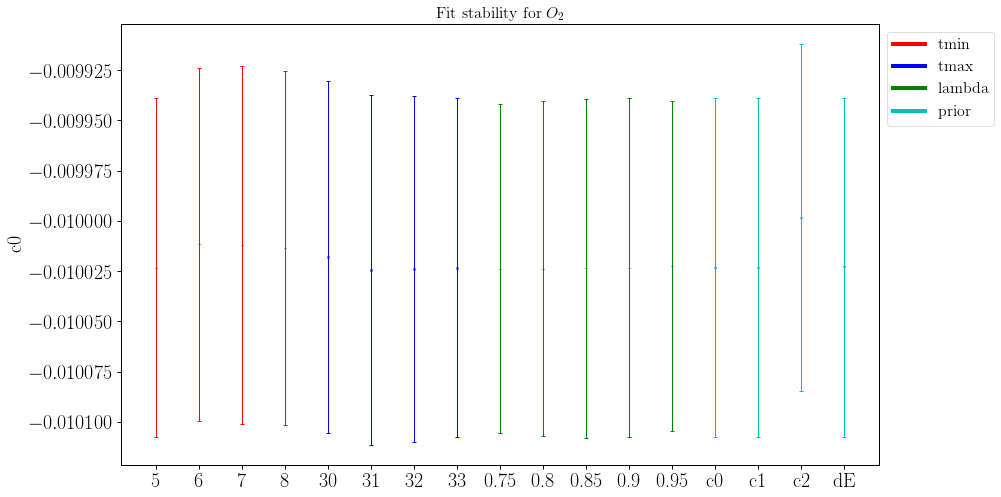

[array([0, 1, 2]), array([3, 4, 5, 6]), array([ 7,  8,  9, 10, 11]), array([12, 13, 14, 15])]
{'8': <lsqfit.nonlinear_fit object at 0x14030e380>, '9': <lsqfit.nonlinear_fit object at 0x14030fc70>, '10': <lsqfit.nonlinear_fit object at 0x14032ab60>}
{'30': <lsqfit.nonlinear_fit object at 0x1403285b0>, '31': <lsqfit.nonlinear_fit object at 0x140329f60>, '32': <lsqfit.nonlinear_fit object at 0x140329e70>, '33': <lsqfit.nonlinear_fit object at 0x13df9c280>}
{'0.75': <lsqfit.nonlinear_fit object at 0x13e267070>, '0.8': <lsqfit.nonlinear_fit object at 0x13e2649a0>, '0.85': <lsqfit.nonlinear_fit object at 0x141007a30>, '0.9': <lsqfit.nonlinear_fit object at 0x1410066b0>, '0.95': <lsqfit.nonlinear_fit object at 0x14041f580>}
{'c0': <lsqfit.nonlinear_fit object at 0x14041ebc0>, 'c1': <lsqfit.nonlinear_fit object at 0x14041d660>, 'c2': <lsqfit.nonlinear_fit object at 0x13db3a650>, 'dE': <lsqfit.nonlinear_fit object at 0x13db3b310>}


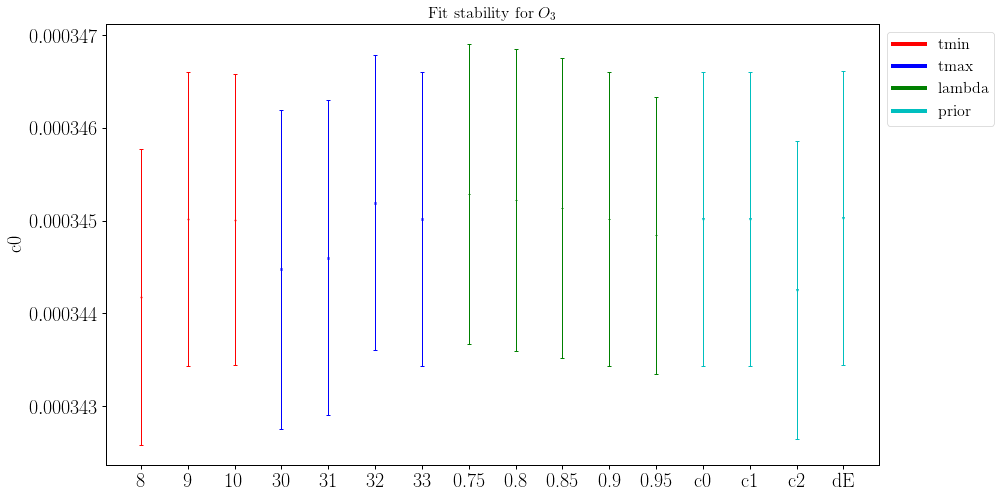

[array([0, 1, 2, 3]), array([4, 5, 6, 7]), array([ 8,  9, 10, 11, 12]), array([13, 14, 15, 16])]
{'5': <lsqfit.nonlinear_fit object at 0x14055ba30>, '6': <lsqfit.nonlinear_fit object at 0x14055b100>, '7': <lsqfit.nonlinear_fit object at 0x13e1e6fe0>, '8': <lsqfit.nonlinear_fit object at 0x13e1e6aa0>}
{'30': <lsqfit.nonlinear_fit object at 0x14036f400>, '31': <lsqfit.nonlinear_fit object at 0x14036e9b0>, '32': <lsqfit.nonlinear_fit object at 0x14036c850>, '33': <lsqfit.nonlinear_fit object at 0x14036e860>}
{'0.75': <lsqfit.nonlinear_fit object at 0x13e2bac80>, '0.8': <lsqfit.nonlinear_fit object at 0x13e2ba0b0>, '0.85': <lsqfit.nonlinear_fit object at 0x13e2b9480>, '0.9': <lsqfit.nonlinear_fit object at 0x13e138610>, '0.95': <lsqfit.nonlinear_fit object at 0x13e139ba0>}
{'c0': <lsqfit.nonlinear_fit object at 0x13e16fa90>, 'c1': <lsqfit.nonlinear_fit object at 0x13e126b00>, 'c2': <lsqfit.nonlinear_fit object at 0x13e126020>, 'dE': <lsqfit.nonlinear_fit object at 0x13e1502b0>}


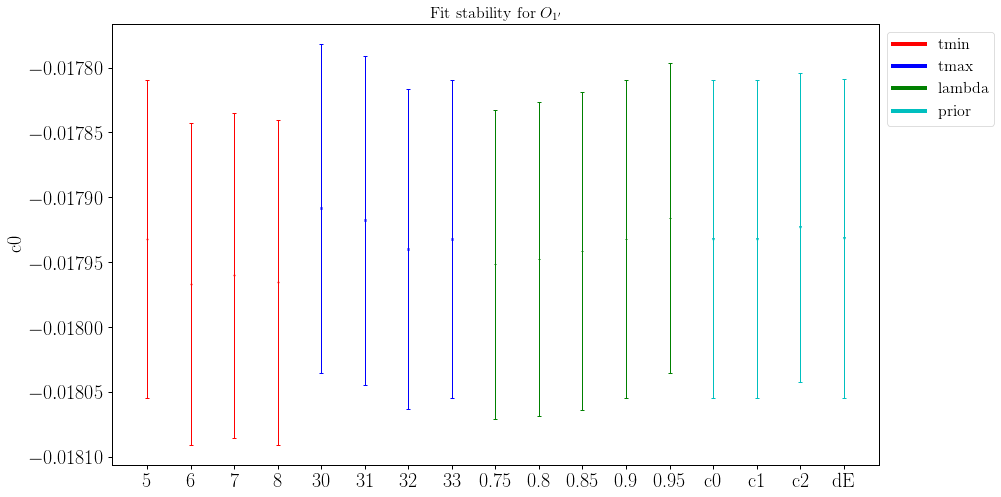

[array([0, 1, 2, 3]), array([4, 5, 6, 7]), array([ 8,  9, 10, 11, 12]), array([13, 14, 15, 16])]
{'5': <lsqfit.nonlinear_fit object at 0x141d51840>, '6': <lsqfit.nonlinear_fit object at 0x141d521a0>, '7': <lsqfit.nonlinear_fit object at 0x141d520b0>, '8': <lsqfit.nonlinear_fit object at 0x1416f4280>}
{'30': <lsqfit.nonlinear_fit object at 0x1416f4700>, '31': <lsqfit.nonlinear_fit object at 0x1416f6650>, '32': <lsqfit.nonlinear_fit object at 0x1416f77f0>, '33': <lsqfit.nonlinear_fit object at 0x141b189d0>}
{'0.75': <lsqfit.nonlinear_fit object at 0x141b18790>, '0.8': <lsqfit.nonlinear_fit object at 0x141b1a860>, '0.85': <lsqfit.nonlinear_fit object at 0x141b1bac0>, '0.9': <lsqfit.nonlinear_fit object at 0x141b20040>, '0.95': <lsqfit.nonlinear_fit object at 0x141b21f60>}
{'c0': <lsqfit.nonlinear_fit object at 0x141b23190>, 'c1': <lsqfit.nonlinear_fit object at 0x141b144c0>, 'c2': <lsqfit.nonlinear_fit object at 0x141b15900>, 'dE': <lsqfit.nonlinear_fit object at 0x141b15d20>}


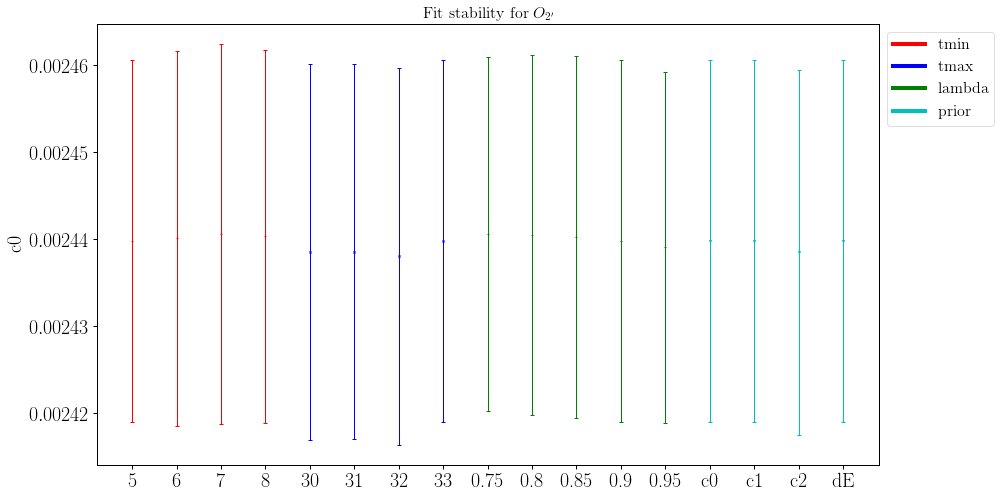

In [50]:
style = styles['notebook']
for k in range(n_ops):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/backprop/stability/' + ens_path \
            + '/' + op_labels[k] + '.pdf'
    plot_stability(k, fit_data, saveat = path)

#### Plot average fit over window

Will need to determine the fit weights and will want to fit each bootstrap as well so that it's correlation with $m_\pi$, $f_\pi$ can be taken into account. 

In [51]:
# unpack fit_data
cut = 0.1
all_cvs, all_stds = [[] for k in range(n_ops)], [[] for k in range(n_ops)]
all_pvals = [[] for k in range(n_ops)]
all_weights = [[] for k in range(n_ops)]
for k in range(n_ops):
    for tmp in fit_data[k].values():
        for ff in tmp.values():
            c0_mu, c0_std = ff.p['c0'].mean, ff.p['c0'].sdev
            pval = ff.Q        # Note ff.Q = scipy.stats.chi2.sf(ff.chi2, ff.dof)
            if pval > cut:
                all_cvs[k].append(c0_mu)
                all_stds[k].append(c0_std)
                all_pvals[k].append(pval)
                all_weights[k].append(pval * (c0_std ** (-2)))
    all_cvs[k], all_stds[k] = np.array(all_cvs[k]), np.array(all_stds[k])
    all_pvals[k], all_weights[k] = np.array(all_pvals[k]), np.array(all_weights[k])
    all_weights[k] = all_weights[k] / np.sum(all_weights[k])        # normalize to 1

In [52]:
# take weighted average
c0_means = []
c0_stds = []
for k in range(n_ops):
    c0bar = np.sum(all_weights[k] * all_cvs[k])
    dc0_stat_sq = np.sum(all_weights[k] * (all_stds[k] ** 2))
    dc0_sys_sq = np.sum(all_weights[k] * ((all_cvs[k] - c0bar)**2))
    c0_sigma = np.sqrt(dc0_stat_sq + dc0_sys_sq)
    c0_means.append(c0bar)
    c0_stds.append(c0_sigma)

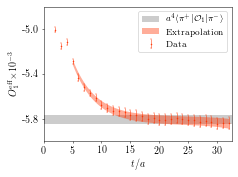

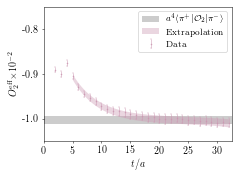

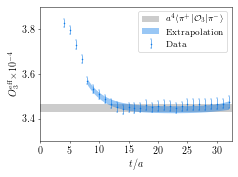

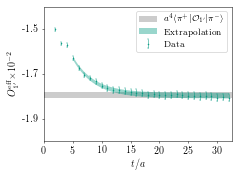

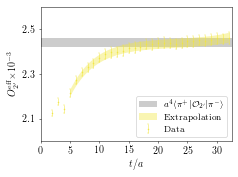

In [53]:
# plot average
style = styles['prd_twocol']
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (exc_domain[k][0], exc_domain[k][-1]))
    #path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems_backprop/' + ens_path + \
    #        '/' + op_labels[k] + '.pdf'
    plot_fit_paper(k, data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, yaxis_labels[k], ylims = \
                   yrangep[k], yt_locs = ytick_locs[k], yt_labels = ytick_labels[k], col = colors[k], \
                   Oeff_mu = c0_means[k], Oeff_sigma = c0_stds[k])#, saveat = path, )

#### Save data

In [54]:
fits = np.array([gen_fake_ensemble([Oeff_cv[k], Oeff_std[k]]) for k in range(n_ops)])
out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + ensemble + '/fit_params_backprop.h5'
fout = h5py.File(out_file, 'w')
fout['fits'] = fits.T
fout['data_slice'] = data_slice
fout['c'] = np.array(Oeff_cv)
fout['sigmac'] = np.array(Oeff_std)
fout['plot_domain'] = plot_domain
for k in range(n_ops):
    fout['fit_domain/' + str(op_labels[k])] = np.array(exc_domain[k], dtype = np.float64)
fout.close()
print('Results output to: ' + out_file)

Results output to: /Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/24I/ml_0p01/fit_params_backprop.h5


# Explicitly derive fit form

The excited state fit forms must be derived explicitly from the spectral decomposition. It's easiest to do this in terms of two parts, the 2-point function and the 3-point function. Upon using the finite-T expansion of these correlation functions, one can derive the following results:
$$
C_{2pt}^{(\mathrm{sub})}(2t) = \frac{|Z_{01}|^2}{2E_1} e^{-2m_\pi t} (1 + a_1 e^{-2\Delta t} + a_2 e^{-(m_\pi + \Delta) T + (2m_\pi + \Delta) 2t} - a_4 e^{-(\frac{\Delta}{2} + m_\pi) T}) \\
C_{3pt}(0, t, 2t) = \frac{|Z_{01}|^2}{4E_1^2} e^{-2m_\pi t} \left[ c_0 + c_1 e^{-\Delta t}  + c_2 e^{-(m_\pi + \Delta) (T - 2t)} \right]
$$
where $m_\pi = E_1 - E_0$ and $\Delta = E_2 - E_1$, and $Z_{nm} = \langle n | \chi_\pi(0) | m\rangle$. I've also assumed that $Z_{nn} = 0$ for any state $n$, since the pion interpolator has negative parity and cannot connect the same state with itself. To simplify this further, we can explicitly plug in for the exponentials to see when each term becomes relevant, and drop the terms that are small and don't contribute at leading order. These are:
- The constant $c_0$ is $\langle\pi|\mathcal O_k |\pi\rangle$ and is the term we wish to extract.
- The $a_1$ and $a_3$ terms are significantly suppressed compared to the $a_2$ term, hence we only use $a_2$ in the model.

Note that at the moment, my normalization of $E_i$ in the denominators may be a bit off, I assumed relativistic normalization for the resolution of the identites I was using but I may need to be a bit more careful.

**Fit form 2 (backprop)**: This fits the data well, but is not accurate and was not derived from the spectral decomposition. 
\begin{equation}
    O = c_0 + c_1 e^{-\Delta t} + c_2 e^{-\Delta (T - t)}
\end{equation}
**Fit form 3 (fiducial)**: Fits the data well, neglects any excited state contamination in $C_{2pt}$.
\begin{equation}
    O = c_0 + c_1 e^{-\Delta t} + c_2 e^{-(m_\pi + \Delta) (T - 2t)}
\end{equation}
**Fit form 4**: Fits the data well and contains the most information from the spectral decomposition. If this continues to work nicely, we should use this. 
\begin{equation}
    O = \frac{c_0 + c_1 e^{-\Delta t} + c_2 e^{-(m_\pi + \Delta) (T - 2t)}}{1 + c_3 e^{-(m_\pi + \Delta) T + (2m_\pi + \Delta)2t} }
\end{equation}
This works well if there's a lot of excited state contamination, but it makes the fits **very unstable** if there is no excited state contamination. 
**Fit form 5**:
Use the $e^{-2\Delta t}$ piece in the denominator. Note this does not work in conjunction with the other denominator term, as the fitter is very unstable.
\begin{equation}
    O = \frac{c_0 + c_1 e^{-\Delta t} + c_2 e^{-(m_\pi + \Delta) (T - 2t)}}{1 + a_1 e^{-2\Delta t}}
\end{equation}
<!-- **Fit form 5**: 
\begin{equation}
    O = \frac{c_0 + c_1 e^{-\Delta t}}{1 + a_2 e^{-2\Delta t} + c_3 e^{-(m_\pi + \Delta) T + (2m_\pi + \Delta)2t} }
\end{equation} -->

For the paper: Fit form 3 contains all the physics and is consistent with fit forms 4 and 5 (for fit form 4, it's a lot more finnicky and unstable). It will be taken as the fiducial fit form, and we should pick a range to vary such that we can add model variation into the stability plots ("Model B" and "Model C" for fit forms 4 and 5). We can then discuss if we should just pick a representative fit window + model for the fit, or if we should take a weighted average over every window. 

In [55]:
mpi_mu = np.mean(mpi_boot)
mpi_std = np.std(mpi_boot, ddof = 1)
Delta_list = [0.0001, 0.001, 0.1]
def denom_full(t, Δ):
    return np.exp(-2*Δ*t) + np.exp(-(mpi_mu + Δ)*T + (2*mpi_mu + Δ) * 2*t) - np.exp(-(Δ/2 + mpi_mu) * T + 2*mpi_mu*t)
def denom1(t, Δ):
    return np.exp(-2*Δ*t)
def denom2(t, Δ):
    return np.exp(-(mpi_mu + Δ)*T + (2*mpi_mu + Δ) * 2*t)
def denom3(t, Δ):
    return np.exp(-(Δ/2 + mpi_mu) * T + 2*mpi_mu*t)
def denom12(t, Δ):
    return np.exp(-(mpi_mu + Δ)*T + (2*mpi_mu + Δ) * 2*t)
def denom31(t, Δ):
    return np.exp(-2*Δ*t) - np.exp(-(Δ/2 + mpi_mu) * T + 2*mpi_mu*t)
def denom23(t, Δ):
    return np.exp(-(mpi_mu + Δ)*T + (2*mpi_mu + Δ) * 2*t) - np.exp(-(Δ/2 + mpi_mu) * T + 2*mpi_mu*t)
def num2(t, Δ):
    return np.exp(-(mpi_mu + Δ) * (T - 2*t))
# denom1_fns = [lambda t : denom1(t, Δ) for Δ in Delta_list]
# denom2_fns = [lambda t : denom2(t, Δ) for Δ in Delta_list]
# denom3_fns = [lambda t : denom3(t, Δ) for Δ in Delta_list]

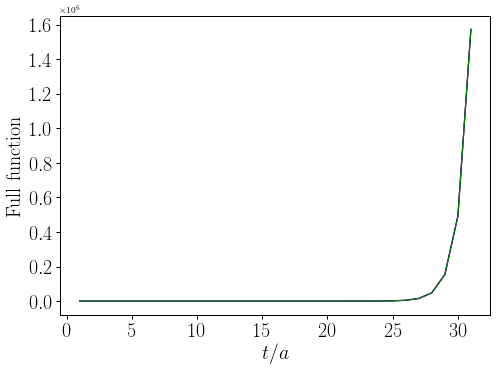

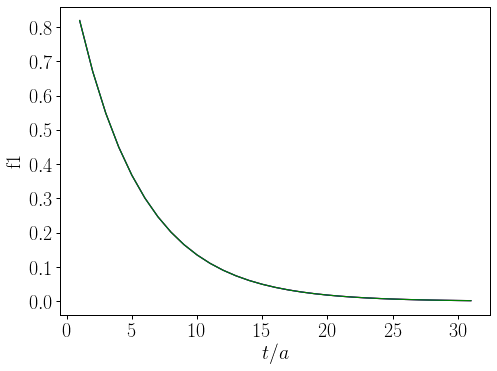

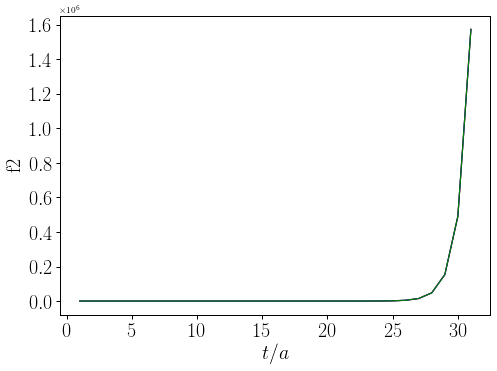

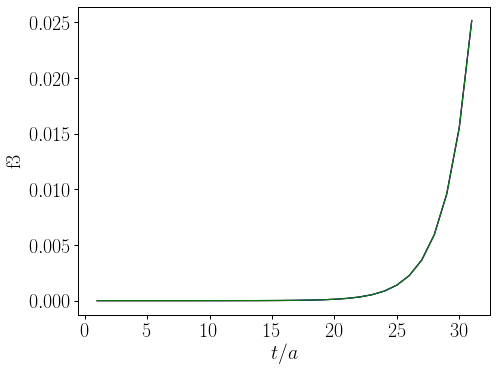

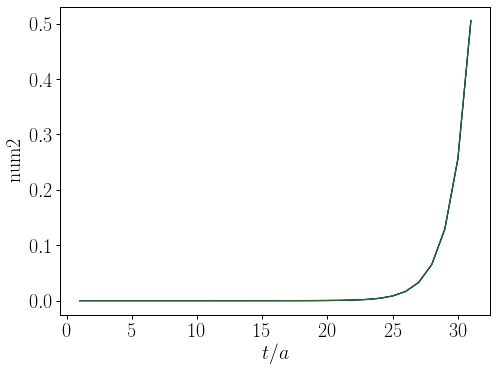

In [56]:
style = styles['notebook']
plot_fns(np.arange(1, 32), [lambda t : denom_full(t, Δ) for Δ in Delta_list], 'Full function', cols = ['r', 'b', 'g'])
plot_fns(np.arange(1, 32), [lambda t : denom1(t, Δ) for Δ in Delta_list], 'f1', cols = ['r', 'b', 'g'])
plot_fns(np.arange(1, 32), [lambda t : denom2(t, Δ) for Δ in Delta_list], 'f2', cols = ['r', 'b', 'g'])
plot_fns(np.arange(1, 32), [lambda t : denom3(t, Δ) for Δ in Delta_list], 'f3', cols = ['r', 'b', 'g'])
plot_fns(np.arange(1, 32), [lambda t : num2(t, Δ) for Δ in Delta_list], 'num2', cols = ['r', 'b', 'g'])

In [57]:
# mpi_mu = np.mean(mpi_boot)
# mpi_std = np.std(mpi_boot, ddof = 1)
# def env_fn(bidx, t):
#     return 1 / (1 + 2 * np.exp(-mpi_boot[bidx] * (T - 2 * t)) + np.exp(-2 * mpi_boot[bidx] * (T - 2 * t)))
# def env_fn_1(t):
#     return 1 / (1 + 2 * np.exp(-mpi_mu * (T - 2 * t)))
# def env_fn_2(t):
#     return 1 / (1 + 2 * np.exp(-mpi_mu * (T - 2 * t)) + np.exp(-2 * mpi_mu * (T - 2 * t)))

In [58]:
# plot_fns(np.arange(1, 32), [env_fn_1, env_fn_2], 'Envelope', cols = ['r', 'b'])

In [59]:
# envelope = np.array([[env_fn(bidx, t) for t in np.arange(0, T)] for bidx in range(n_boot)])
# # data_slice_prime = np.einsum('bkt,t->bkt', data_slice, envelope)
# data_slice_prime = np.einsum('bkt,bt->bkt', data_slice, envelope)
# data_slice_prime_mu = np.mean(data_slice_prime, axis = 0)
# data_slice_prime_std = np.std(data_slice_prime, ddof = 1, axis = 0)

#### Choose fit form here

In [60]:
# fitform = 'f3'
# fitform = 'f4'
# fitform = 'f5'
fitform = 'f6'

In [61]:
if fitform == 'f3' or fitform == 'f5' or fitform == 'f6':
    exc_domain = [
        # [np.arange(5, 33), np.arange(5, 33), np.arange(8, 33), np.arange(5, 33), np.arange(5, 33)],
        [np.arange(6, 33), np.arange(6, 33), np.arange(9, 33), np.arange(6, 33), np.arange(6, 33)], 
        [np.arange(6, 33), np.arange(6, 33), np.arange(9, 33), np.arange(6, 33), np.arange(6, 33)], 
        [np.arange(6, 33), np.arange(6, 33), np.arange(9, 33), np.arange(6, 33), np.arange(6, 33)], 
        [np.arange(6, 33), np.arange(6, 33), np.arange(9, 33), np.arange(6, 33), np.arange(6, 33)], 
#         [np.arange(6, 33), np.arange(6, 33), np.arange(8, 33), np.arange(6, 33), np.arange(6, 33)]
        [np.arange(6, 33), np.arange(6, 33), np.arange(9, 33), np.arange(6, 33), np.arange(6, 33)]
    ][ens_idx]
    #     exc_domain = [
    #         [np.arange(5, 33), np.arange(5, 33), np.arange(8, 33), np.arange(5, 33), np.arange(5, 33)], 
    #         [np.arange(5, 33), np.arange(5, 33), np.arange(8, 33), np.arange(5, 33), np.arange(5, 33)], 
    #         [np.arange(5, 33), np.arange(5, 33), np.arange(8, 33), np.arange(5, 33), np.arange(5, 33)], 
    #         [np.arange(5, 33), np.arange(5, 33), np.arange(8, 33), np.arange(5, 33), np.arange(5, 33)], 
    #         [np.arange(5, 33), np.arange(5, 33), np.arange(9, 33), np.arange(5, 33), np.arange(5, 33)]
    #     ][ens_idx]
else:    # then we have f4
    exc_domain = [
        [np.arange(8, 31), np.arange(8, 31), np.arange(11, 30), np.arange(8, 31), np.arange(8, 31)], 
        [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
        [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
        [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
        [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
        [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
    ][ens_idx]
    #     exc_domain = [
    #         [np.arange(8, 31), np.arange(8, 31), np.arange(11, 30), np.arange(8, 31), np.arange(8, 31)], 
    #         [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
    #         [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
    #         [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
    #         [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
    #         [np.arange(8, 31), np.arange(8, 31), np.arange(8, 33), np.arange(8, 31), np.arange(8, 31)], 
    #     ][ens_idx]

In [62]:
# assemble data into correct form
def make_data(corr, domain, lam = 1):
    """
    Makes data for lsqfit. corr is an np.array of shape (n_boot, T). Here lam is the shrinkage parameter λ, which is 
    set to 1 (fully correlated) by default. 
    """
    d = {t : corr[:, t] for t in domain}
    df = pd.DataFrame(d)
    mean = np.array(df.mean())
    full_cov = np.array(df.cov())
    cov = shrinkage(full_cov, lam)    # try shrinkage
    #cov = np.array(df.cov())
    return domain, gv.gvar(mean, cov)

# f3
if fitform == 'f3':
    def make_prior(c_widths = [0.1, 0.1, 0.1, 0.1], dE_width = 0.4):
        """
        Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
        In the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
        """
        prior = gv.BufferDict()
        prior['c0'] = gv.gvar(0.0, c_widths[0])
        prior['c1'] = gv.gvar(0.0, c_widths[1])
        prior['c2'] = gv.gvar(0.0, c_widths[2])
        prior['log(dE)'] = np.log(gv.gvar(0.1, dE_width))    # be more judicious and make this have a larger gap
        prior['log(m)'] = np.log(gv.gvar(mpi_mu, mpi_std))
        return prior
    def fcn(t, p):
        """Single exponential fitting function + backpropagating state."""
        c0 = p['c0']
        c1 = p['c1']
        c2 = p['c2']
        dE = p['dE']
        m = p['m']
        return (c0 + c1*np.exp(-dE*t) + c2 * np.exp(-(m + dE)*(T - 2*t)))
    fitform = 'f3'
    c_width = [0.1, 0.1, 0.1]
    prior_strs = ['c0', 'c1', 'c2', 'dE']

# f4
if fitform == 'f4':
    def make_prior(c_widths = [0.1, 0.1, 0.1, 0.1], dE_width = 0.4):
        """
        Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
        In the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
        """
        prior = gv.BufferDict()
        prior['c0'] = gv.gvar(0.0, c_widths[0])
        prior['c1'] = gv.gvar(0.0, c_widths[1])
        prior['c2'] = gv.gvar(0.0, c_widths[2])
        prior['c3'] = gv.gvar(0.0, c_widths[3])
        prior['log(dE)'] = np.log(gv.gvar(0.1, dE_width))    # be more judicious and make this have a larger gap
        prior['log(m)'] = np.log(gv.gvar(mpi_mu, mpi_std))
        return prior
    def fcn(t, p):
        """Single exponential fitting function + backpropagating state."""
        c0 = p['c0']
        c1 = p['c1']
        c2 = p['c2']
        c3 = p['c3']
        dE = p['dE']
        m = p['m']
        return (c0 + c1*np.exp(-dE*t) + c2 * np.exp(-(m + dE)*(T - 2*t))) / (1+c3*np.exp(-(m + dE)*T + (2*m+dE)*2*t))
    fitform = 'f4'
    c_width = [0.1, 0.1, 0.1, 0.1]
    prior_strs = ['c0', 'c1', 'c2', 'c3', 'dE']

# f5
if fitform == 'f5':
    def make_prior(c_widths = [0.1, 0.1, 0.1, 0.1], dE_width = 0.4):
        """
        Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
        In the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential.
        """
        prior = gv.BufferDict()
        prior['c0'] = gv.gvar(0.0, c_widths[0])
        prior['c1'] = gv.gvar(0.0, c_widths[1])
        prior['c2'] = gv.gvar(0.0, c_widths[2])
        prior['c3'] = gv.gvar(0.0, c_widths[3])
        prior['log(dE)'] = np.log(gv.gvar(0.1, dE_width))    # be more judicious and make this have a larger gap
        prior['log(m)'] = np.log(gv.gvar(mpi_mu, mpi_std))
        return prior
    def fcn(t, p):
        """Single exponential fitting function + backpropagating state."""
        c0 = p['c0']
        c1 = p['c1']
        c2 = p['c2']
        c3 = p['c3']
        dE = p['dE']
        m = p['m']
        return (c0 + c1*np.exp(-dE*t) + c2 * np.exp(-(m + dE)*(T - 2*t))) / (1 + c3*np.exp(-2*dE*t))
    fitform = 'f5'
    c_width = [0.1, 0.1, 0.1, 0.1]
    prior_strs = ['c0', 'c1', 'c2', 'c3', 'dE']

# f6 (Taylor expansion)
if fitform == 'f6':
    def make_prior(c_widths = [0.1, 0.1, 0.1, 0.1, 0.1], dE_width = 0.1):
        """
        Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
        In the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential.
        """
        prior = gv.BufferDict()
        prior['c0'] = gv.gvar(0.0, c_widths[0])
        prior['c1'] = gv.gvar(0.0, c_widths[1])
        prior['c2'] = gv.gvar(0.0, c_widths[2])
        prior['c3'] = gv.gvar(0.0, c_widths[3])
        prior['c4'] = gv.gvar(0.0, c_widths[4])
        #prior['log(dE)'] = np.log(gv.gvar(0.1, dE_width))    # be more judicious and make this have a larger gap
        #prior['log(dE)'] = np.log(gv.gvar(mpi_mu, 0.1))    # be more judicious and make this have a larger gap
        prior['log(dE)'] = np.log(gv.gvar(mpi_mu, dE_width))    # be more judicious and make this have a larger gap
        prior['log(m)'] = np.log(gv.gvar(mpi_mu, mpi_std))
        return prior
    def fcn(t, p):
        """Single exponential fitting function + backpropagating state."""
        c0 = p['c0']
        c1 = p['c1']
        c2 = p['c2']
        c3 = p['c3']
        c4 = p['c4']
        dE = p['dE']
        m = p['m']
        return c0 + c1*np.exp(-dE*t) + c2 * np.exp(-(m + dE)*(T - 2*t)) - c3*np.exp(-2*dE*t) - c4*np.exp(-(m + dE)*T + (2*m+dE)*2*t)
    fitform = 'f6'
    c_width = [0.1, 0.1, 0.1, 0.1, 0.1]
    prior_strs = ['c0', 'c1', 'c2', 'c3', 'c4', 'dE']

In [63]:
# Fit data_slice[b, k, t]. 
fit_outs = []
fit_chi2_dof = []
Oeff_cv = []
Oeff_std = []
# λ = 0.95
λ = 0.9
# λ = 1.0
for k in range(n_ops):
    print('Fitting ' + op_labels[k])
    domain = exc_domain[k]
    fit_data = data_slice[:, k, :]
    t_dom, Oeff = make_data(fit_data, domain, λ)
    prior = make_prior()
    p0 = None
    fit = lsqfit.nonlinear_fit(data = (t_dom, Oeff), fcn = fcn, prior = prior, p0 = p0)
    
    # print fit and save parameters
    print(fit)
    fit_outs.append(fit)
    fit_chi2_dof.append(fit.chi2 / fit.dof)
    Oeff_cv.append(fit.p['c0'].mean)
    Oeff_std.append(fit.p['c0'].sdev)
Oeff_cv = np.array(Oeff_cv)
Oeff_std = np.array(Oeff_std)

Fitting O1
Least Square Fit:
  chi2/dof [dof] = 0.29 [27]    Q = 1    logGBF = 214.89

Parameters:
             c0   -0.005803 (42)       [    0.00 (10) ]  
             c1      0.0014 (11)       [    0.00 (10) ]  
             c2    -0.00015 (15)       [    0.00 (10) ]  
             c3     -0.0001 (21)       [    0.00 (10) ]  
             c4    -2.3(2.8)e-11       [    0.00 (10) ]  
        log(dE)       -1.52 (33)       [   -1.42 (41) ]  
         log(m)     -1.4224 (22)       [ -1.4224 (22) ]  
-------------------------------------------------------
             dE       0.219 (71)       [    0.24 (10) ]  
              m     0.24114 (54)       [ 0.24115 (54) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08,1e-10,1e-10*)    (itns/time = 11/0.0)
  fitter = scipy_least_squares    method = trf

Fitting O2
Least Square Fit:
  chi2/dof [dof] = 0.22 [27]    Q = 1    logGBF = 199.09

Parameters:
             c0   -0.010020 (91)       [    0.00 (10) ]  
             c1      0.0024 (19)

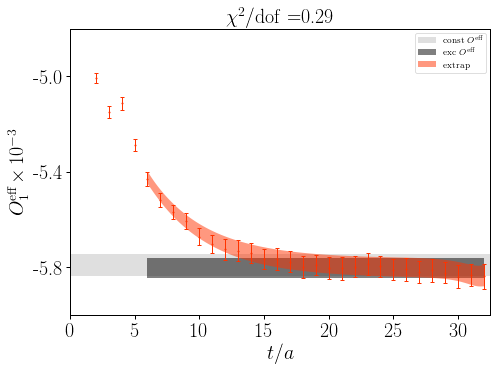

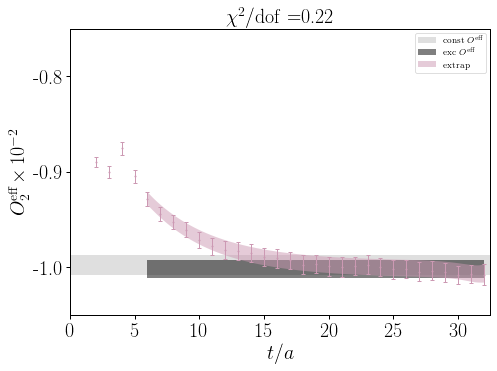

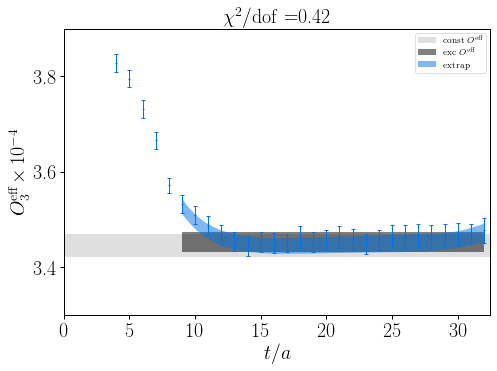

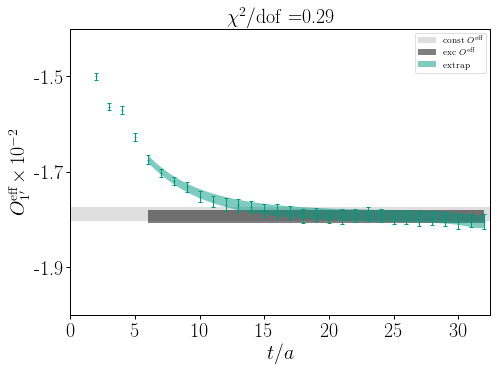

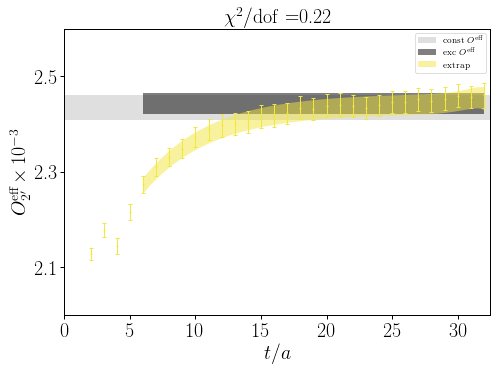

In [64]:
style = styles['notebook']
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (exc_domain[k][0], exc_domain[k][-1]))
    O_mu, O_std = fit_outs[k].p['c0'].mean, fit_outs[k].p['c0'].sdev
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/' + fitform + '/comparisons/' \
            + ens_path + '/' + op_labels[k] + '.pdf'
    plot_fit(data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, yaxis_labels[k], ylims = \
        yrangep[k], yt_locs = ytick_locs[k], yt_labels = ytick_labels[k], col = colors[k], Oeff_mu = Oeff_cv[k], \
        Oeff_sigma = Oeff_std[k], const_mu = c[k], const_sigma = sigmac[k], chi2_dof = fit_chi2_dof[k], saveat = path)

#### Stability plots for derived fit form

In [65]:
# tmin0, tmin_rg = 5, [5, 6, 7, 8]
# tmin0, tmin_rg = 8, [5, 6, 7, 8]
tmin0, tmin_rg = exc_domain[0][0], [6, 7, 8]
# tmin0_O3, tmin_rg_O3 = 9, [8, 9, 10]        # O3 has more excited state contamination
tmin0_O3, tmin_rg_O3 = exc_domain[2][0], [9, 10, 11]        # O3 has more excited state contamination
# tmax0, tmax_rg = 33, [31, 32, 33]
# tmax0, tmax_rg = 31, [31, 32, 33]
tmax0, tmax_rg = exc_domain[0][-1], [31, 32, 33]
lam0, lam_rg = 0.9, np.arange(0.75, 1.0, 0.05)
ll_strs = ['0.75', '0.8', '0.85', '0.9', '0.95']

dE_width = 0.4
prior_widths = copy(c_width)
prior_widths.append(dE_width)
n_priors = len(prior_widths)
key_labels = ['tmin', 'tmax', 'lambda', 'prior']
n_keys = len(key_labels)

In [66]:
# vary t_{min} and see how the posterior for the extracted matrix element reacts
fit_data = [{'tmin' : {}, 'tmax' : {}, 'lambda' : {}, 'prior' : {}} for k in range(n_ops)]
prior_vary = [[10 * prior_widths[i] if i == j else prior_widths[i] for i in range(n_priors)] for j in range(n_priors)]
p0 = None
p_cut = 0.01
for k in range(n_ops):
    print('Stability with single-exp + backpropr for O' + str(k))
    Tmin0 = tmin0_O3 if k == 2 else tmin0
    Tmin_rg = tmin_rg_O3 if k == 2 else tmin_rg
    for tm in Tmin_rg:
        tmp = perform_fit(k, tm, tmax0, lam0, c_width, dE_width)
        if tmp.Q > p_cut:
            fit_data[k]['tmin'][str(tm)] = tmp
    for tp in tmax_rg:
        tmp = perform_fit(k, Tmin0, tp, lam0, c_width, dE_width)
        if tmp.Q > p_cut:
            fit_data[k]['tmax'][str(tp)] = tmp
    for il, ll in enumerate(lam_rg):
        ll_key = ll_strs[il]
        tmp = perform_fit(k, Tmin0, tmax0, ll, c_width, dE_width)
        if tmp.Q > p_cut:
            fit_data[k]['lambda'][ll_key] = tmp
    for ip in range(n_priors):
        tmp = perform_fit(k, Tmin0, tmax0, lam0, prior_vary[ip][:n_priors-1], prior_vary[ip][n_priors - 1])
        if tmp.Q > p_cut:
            fit_data[k]['prior'][prior_strs[ip]] = tmp
#     for tm in Tmin_rg:
#         fit_data[k]['tmin'][str(tm)] = perform_fit(k, tm, tmax0, lam0, c_width, dE_width)
#     for tp in tmax_rg:
#         fit_data[k]['tmax'][str(tp)] = perform_fit(k, Tmin0, tp, lam0, c_width, dE_width)
#     for il, ll in enumerate(lam_rg):
#         ll_key = ll_strs[il]
#         fit_data[k]['lambda'][ll_key] = perform_fit(k, Tmin0, tmax0, ll, c_width, dE_width)
#     for ip in range(n_priors):
#         fit_data[k]['prior'][prior_strs[ip]] = perform_fit(k, Tmin0, tmax0, lam0, prior_vary[ip][:n_priors-1], \
#                                                            prior_vary[ip][n_priors - 1])

Stability with single-exp + backpropr for O0
Stability with single-exp + backpropr for O1
Stability with single-exp + backpropr for O2
Stability with single-exp + backpropr for O3
Stability with single-exp + backpropr for O4


[array([0, 1, 2]), array([3, 4, 5]), array([ 6,  7,  8,  9, 10]), array([11, 12, 13, 14, 15, 16])]
{'6': <lsqfit.nonlinear_fit object at 0x141ab0c40>, '7': <lsqfit.nonlinear_fit object at 0x141ab38b0>, '8': <lsqfit.nonlinear_fit object at 0x141d25a20>}
{'31': <lsqfit.nonlinear_fit object at 0x141d257e0>, '32': <lsqfit.nonlinear_fit object at 0x141d268c0>, '33': <lsqfit.nonlinear_fit object at 0x1418e3610>}
{'0.75': <lsqfit.nonlinear_fit object at 0x1418e31f0>, '0.8': <lsqfit.nonlinear_fit object at 0x141963d30>, '0.85': <lsqfit.nonlinear_fit object at 0x1419601f0>, '0.9': <lsqfit.nonlinear_fit object at 0x1419dac50>, '0.95': <lsqfit.nonlinear_fit object at 0x1419d9ae0>}
{'c0': <lsqfit.nonlinear_fit object at 0x14197b8b0>, 'c1': <lsqfit.nonlinear_fit object at 0x1418a4f40>, 'c2': <lsqfit.nonlinear_fit object at 0x1418a5840>, 'c3': <lsqfit.nonlinear_fit object at 0x141814820>, 'c4': <lsqfit.nonlinear_fit object at 0x141816440>, 'dE': <lsqfit.nonlinear_fit object at 0x1419170d0>}


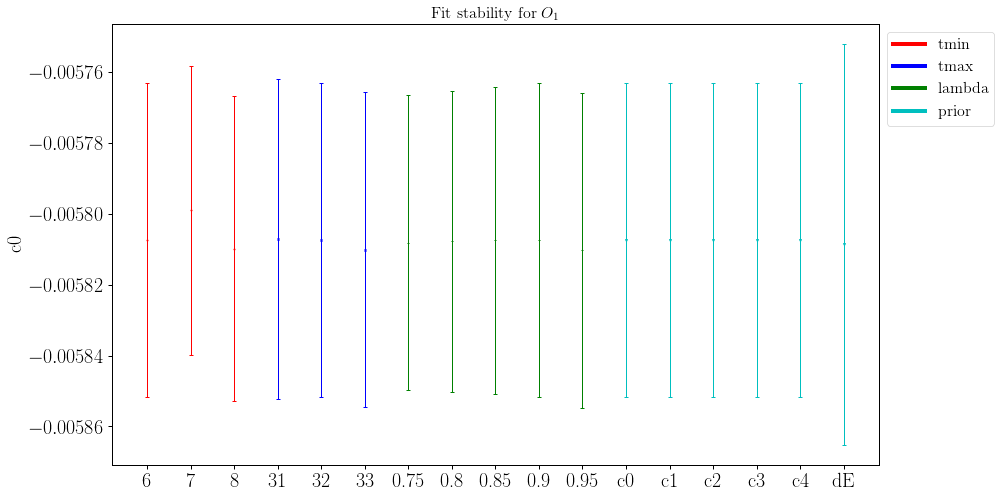

[array([0, 1, 2]), array([3, 4, 5]), array([ 6,  7,  8,  9, 10]), array([11, 12, 13, 14, 15, 16])]
{'6': <lsqfit.nonlinear_fit object at 0x1419176a0>, '7': <lsqfit.nonlinear_fit object at 0x141855ba0>, '8': <lsqfit.nonlinear_fit object at 0x14186e0e0>}
{'31': <lsqfit.nonlinear_fit object at 0x14186de40>, '32': <lsqfit.nonlinear_fit object at 0x14188c220>, '33': <lsqfit.nonlinear_fit object at 0x14188c040>}
{'0.75': <lsqfit.nonlinear_fit object at 0x1417e9060>, '0.8': <lsqfit.nonlinear_fit object at 0x1417e8a00>, '0.85': <lsqfit.nonlinear_fit object at 0x1417b3bb0>, '0.9': <lsqfit.nonlinear_fit object at 0x1417fa710>, '0.95': <lsqfit.nonlinear_fit object at 0x1417f8d90>}
{'c0': <lsqfit.nonlinear_fit object at 0x1417ccf40>, 'c1': <lsqfit.nonlinear_fit object at 0x1417ce890>, 'c2': <lsqfit.nonlinear_fit object at 0x14182f280>, 'c3': <lsqfit.nonlinear_fit object at 0x14182df30>, 'c4': <lsqfit.nonlinear_fit object at 0x14171ccd0>, 'dE': <lsqfit.nonlinear_fit object at 0x14171c5b0>}


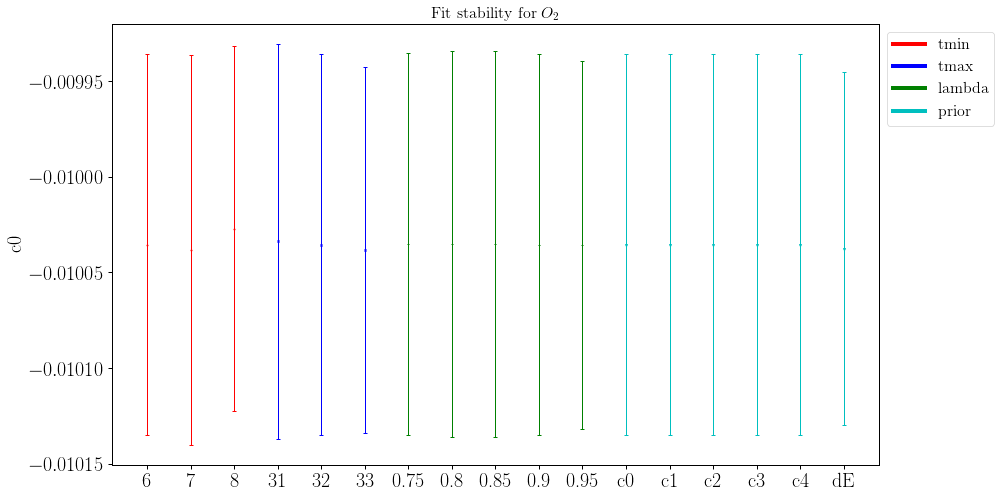

[array([0, 1, 2]), array([3, 4, 5]), array([ 6,  7,  8,  9, 10]), array([11, 12, 13, 14, 15, 16])]
{'9': <lsqfit.nonlinear_fit object at 0x14171c8b0>, '10': <lsqfit.nonlinear_fit object at 0x141a9e3e0>, '11': <lsqfit.nonlinear_fit object at 0x141a9d360>}
{'31': <lsqfit.nonlinear_fit object at 0x141a9d1e0>, '32': <lsqfit.nonlinear_fit object at 0x141a47070>, '33': <lsqfit.nonlinear_fit object at 0x141a45120>}
{'0.75': <lsqfit.nonlinear_fit object at 0x141a46b30>, '0.8': <lsqfit.nonlinear_fit object at 0x1419ed240>, '0.85': <lsqfit.nonlinear_fit object at 0x1419ed300>, '0.9': <lsqfit.nonlinear_fit object at 0x1419ec490>, '0.95': <lsqfit.nonlinear_fit object at 0x1415d7310>}
{'c0': <lsqfit.nonlinear_fit object at 0x141796ce0>, 'c1': <lsqfit.nonlinear_fit object at 0x141796dd0>, 'c2': <lsqfit.nonlinear_fit object at 0x141795840>, 'c3': <lsqfit.nonlinear_fit object at 0x1416c3610>, 'c4': <lsqfit.nonlinear_fit object at 0x1416c0f70>, 'dE': <lsqfit.nonlinear_fit object at 0x1416c3700>}


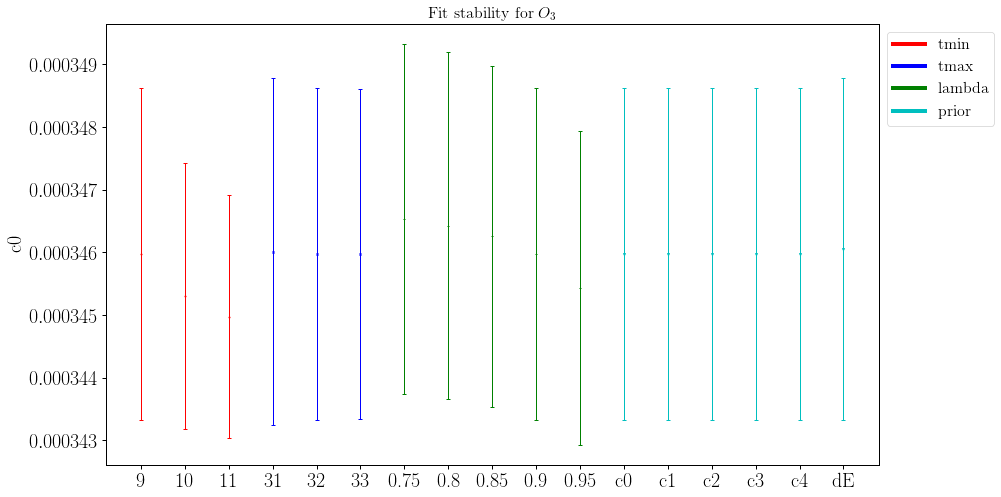

[array([0, 1, 2]), array([3, 4, 5]), array([ 6,  7,  8,  9, 10]), array([11, 12, 13, 14, 15, 16])]
{'6': <lsqfit.nonlinear_fit object at 0x141780ee0>, '7': <lsqfit.nonlinear_fit object at 0x141782560>, '8': <lsqfit.nonlinear_fit object at 0x141614970>}
{'31': <lsqfit.nonlinear_fit object at 0x1416163b0>, '32': <lsqfit.nonlinear_fit object at 0x141617cd0>, '33': <lsqfit.nonlinear_fit object at 0x141675840>}
{'0.75': <lsqfit.nonlinear_fit object at 0x141676590>, '0.8': <lsqfit.nonlinear_fit object at 0x141674be0>, '0.85': <lsqfit.nonlinear_fit object at 0x1416e9b10>, '0.9': <lsqfit.nonlinear_fit object at 0x1416eb250>, '0.95': <lsqfit.nonlinear_fit object at 0x1416ea050>}
{'c0': <lsqfit.nonlinear_fit object at 0x14071db40>, 'c1': <lsqfit.nonlinear_fit object at 0x14071d120>, 'c2': <lsqfit.nonlinear_fit object at 0x14071d990>, 'c3': <lsqfit.nonlinear_fit object at 0x14067e560>, 'c4': <lsqfit.nonlinear_fit object at 0x14067f5b0>, 'dE': <lsqfit.nonlinear_fit object at 0x14067f010>}


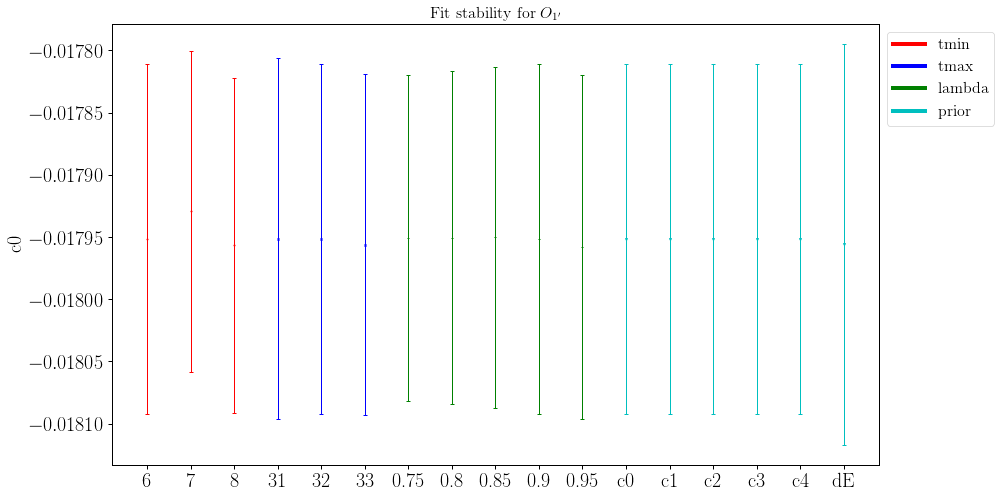

[array([0, 1, 2]), array([3, 4, 5]), array([ 6,  7,  8,  9, 10]), array([11, 12, 13, 14, 15, 16])]
{'6': <lsqfit.nonlinear_fit object at 0x140460ee0>, '7': <lsqfit.nonlinear_fit object at 0x1404622c0>, '8': <lsqfit.nonlinear_fit object at 0x141b211e0>}
{'31': <lsqfit.nonlinear_fit object at 0x141b21510>, '32': <lsqfit.nonlinear_fit object at 0x1404423e0>, '33': <lsqfit.nonlinear_fit object at 0x140441ff0>}
{'0.75': <lsqfit.nonlinear_fit object at 0x13e2b9d20>, '0.8': <lsqfit.nonlinear_fit object at 0x141b164d0>, '0.85': <lsqfit.nonlinear_fit object at 0x141b14250>, '0.9': <lsqfit.nonlinear_fit object at 0x14074b010>, '0.95': <lsqfit.nonlinear_fit object at 0x13e125c90>}
{'c0': <lsqfit.nonlinear_fit object at 0x14055ba30>, 'c1': <lsqfit.nonlinear_fit object at 0x13e1e6c20>, 'c2': <lsqfit.nonlinear_fit object at 0x14030ca60>, 'c3': <lsqfit.nonlinear_fit object at 0x14030f4f0>, 'c4': <lsqfit.nonlinear_fit object at 0x14041f9a0>, 'dE': <lsqfit.nonlinear_fit object at 0x14041e290>}


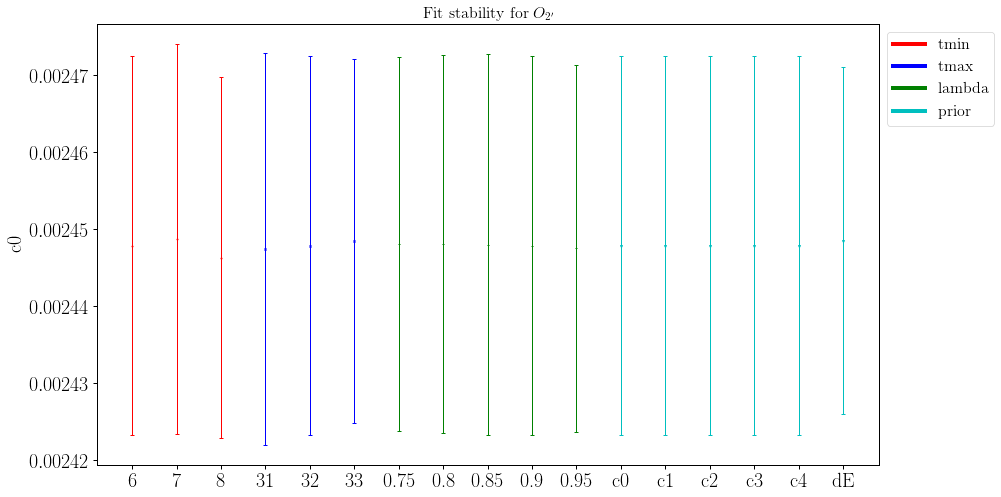

In [67]:
style = styles['notebook']
for k in range(n_ops):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/' + fitform + '/stability/' \
            + ens_path + '/' + op_labels[k] + '.pdf'
    plot_stability(k, fit_data, saveat = path, n_priors = n_priors)

#### Plot average fit over window

In [68]:
# unpack fit_data
cut = 0.1
all_cvs, all_stds = [[] for k in range(n_ops)], [[] for k in range(n_ops)]
all_pvals = [[] for k in range(n_ops)]
all_weights = [[] for k in range(n_ops)]
for k in range(n_ops):
    for tmp in fit_data[k].values():
        for ff in tmp.values():
            c0_mu, c0_std = ff.p['c0'].mean, ff.p['c0'].sdev
            pval = ff.Q        # Note ff.Q = scipy.stats.chi2.sf(ff.chi2, ff.dof)
            if pval > cut:
                all_cvs[k].append(c0_mu)
                all_stds[k].append(c0_std)
                all_pvals[k].append(pval)
                all_weights[k].append(pval * (c0_std ** (-2)))
    all_cvs[k], all_stds[k] = np.array(all_cvs[k]), np.array(all_stds[k])
    all_pvals[k], all_weights[k] = np.array(all_pvals[k]), np.array(all_weights[k])
    all_weights[k] = all_weights[k] / np.sum(all_weights[k])        # normalize to 1

In [69]:
# take weighted average
c0_means = []
c0_stds = []
for k in range(n_ops):
    c0bar = np.sum(all_weights[k] * all_cvs[k])
    dc0_stat_sq = np.sum(all_weights[k] * (all_stds[k] ** 2))
    dc0_sys_sq = np.sum(all_weights[k] * ((all_cvs[k] - c0bar)**2))
    c0_sigma = np.sqrt(dc0_stat_sq + dc0_sys_sq)
    c0_means.append(c0bar)
    c0_stds.append(c0_sigma)

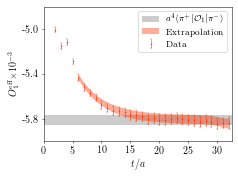

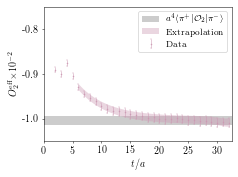

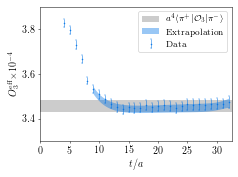

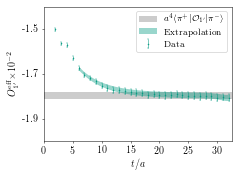

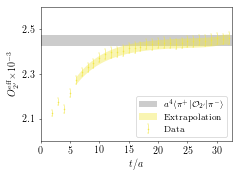

In [70]:
# plot average
style = styles['prd_twocol']
for k in range(n_ops):
    fit_x, fit_lower, fit_upper = get_fit_band(fit_outs[k].p, fcn, xlims = (exc_domain[k][0], exc_domain[k][-1]))
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/' + fitform + '/' + ens_path + \
           '/' + op_labels[k] + '.pdf'
    plot_fit_paper(k, data_plot_mu[k], data_plot_sigma[k], fit_x, fit_lower, fit_upper, yaxis_labels[k], ylims = \
                   yrangep[k], yt_locs = ytick_locs[k], yt_labels = ytick_labels[k], col = colors[k], \
                   Oeff_mu = c0_means[k], Oeff_sigma = c0_stds[k], saveat = path)

## Try to fit $R'$

#### Get $\mathcal Z_0$

In [71]:
# # rescale C2pt
# C2pt_scale = np.real(C2pt_tavg / (vol))    # also try 4-dim volume if we need it
# C2_scale_folded = np.real(fold(C2pt_scale, T))
# C2_scale_folded_mu = np.mean(C2_scale_folded, axis = 0)
# C2_scale_folded_std = np.std(C2_scale_folded, ddof = 1, axis = 0)

In [72]:
# def make_data(corr, domain):
#     """
#     Makes data for lsqfit. corr is an np.array of shape (n_boot, T).
#     """
#     d = {t : corr[:, t] for t in domain}
#     df = pd.DataFrame(d)
#     mean = np.array(df.mean())
#     cov = np.array(df.cov())
#     return mpi_domain, gv.gvar(mean, cov)

# def make_prior():
#     """
#     Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
#     Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
#     """
#     prior = gv.BufferDict()
#     prior['Z0'] = gv.gvar(1e5, 1e5)
#     #prior['Z0'] = gv.gvar(40, 40)
#     prior['Z1'] = gv.gvar(1e5, 1e5)
#     #prior['Z2'] = gv.gvar(40, 40)
#     prior['m'] = gv.gvar(0.25, 0.05)
#     #prior['log(dE)'] = np.log(gv.gvar(0.1, 0.4))
#     return prior

# def fcn(t, p):
#     """Exponential fitting function f(t) = Z0 e^{-mt} + Z1 e^{-m(T - t)}."""
#     Z0 = p['Z0']
#     Z1 = p['Z1']
#     #Z2 = p['Z2']
#     m = p['m']
#     #dE = p['dE']
#     return (Z0**2 / (2 * m)) * np.exp(-m * t) + Z1 * np.exp(-m * (T - t))# + Z2 * np.exp(-(m + dE) * t)

In [73]:
# # mpi_domain = np.arange(10, 25)    # domain to modify
# mpi_domain = np.arange(9, 18)    # domain to modify
# t_dom, C2 = make_data(C2_scale_folded, mpi_domain)
# prior = make_prior()
# p0 = None
# fit = lsqfit.nonlinear_fit(data = (t_dom, C2), fcn = fcn, prior = prior, p0 = p0)
# print(fit)
# mean_c, std_c = fit.p['m'].mean, fit.p['m'].sdev
# Z0_mu, Z0_std = fit.p['Z0'].mean, fit.p['Z0'].sdev
# Z1_mu, Z1_std = fit.p['Z1'].mean, fit.p['Z1'].sdev

In [74]:
# fit_x, fit_lower, fit_upper = get_fit_band(fit.p, fcn, xlims = (mpi_domain[0], mpi_domain[-1]))
# plot_fit(C2_scale_folded_mu, C2_scale_folded_std, fit_x, fit_lower, fit_upper, '$C_{2\mathrm{pt}}$', ylims = (0, 1000))

#### Fit $R'$

The typical R-ratio that we construct is:
$$
R(t)\equiv 2 am_\pi \frac{\mathcal C_k(0, t, 2t)}{\mathcal C_{2\mathrm{pt}}(2t) - \frac{1}{2} \mathcal C_{2\mathrm{pt}}(T / 2) e^{m_\pi (2t - T / 2)}}
$$
We subtract off the $C_{2pt}(T / 2)$ in the denominator to subtract off the positive propagating mode, so that the exponentials cancel and the ratio asymptotes to a constant. However, it may be easier in this case to not subtract that off, as we're fitting all the exponentials at once. Furthermore, when we're being careful about the back-propagating piece, we end up with extra terms which can't be easily cancelled with a single application of $C_{2\mathrm{pt}}$. Instead, we should consider what CalLat used:
$$
R'(t)\equiv \frac{\mathcal C_k(0, t, 2t)}{\mathcal C_{2\mathrm{pt}}(t) \mathcal C_{2\mathrm{pt}}(T - t)}
$$

In [75]:
# # construct R'
# Rp = np.zeros((n_boot, n_ops, T // 2), dtype = np.float64)
# for bidx in range(n_boot):
#     for k in range(n_ops):
#         for t in range(T // 2):
#             Rp[bidx, k, t] = (np.abs(Z0_mu)**2) * np.real(Cnpt[bidx, k, t, 2*t] / (C2pt_scale[bidx, t] * C2pt_scale[bidx, T - (t + 1)])) / vol
# Rp_mu = np.mean(Rp, axis = 0)
# Rp_std = np.std(Rp, axis = 0, ddof = 1)

In [76]:
# for k in range(n_ops):
#     print('Plotting operator ' + str(op_labels[k]))
#     plot_data(Rp_mu[k], Rp_std[k], str(op_labels[k]))

In [77]:
# Rp_domain = [
#     [np.arange(5, 32), np.arange(5, 32), np.arange(8, 30), np.arange(5, 32), np.arange(5, 32)],
#     [np.arange(7, 20), np.arange(7, 20), np.arange(5, 16), np.arange(7, 20), np.arange(7, 20)],
#     [np.arange(5, 32), np.arange(5, 32), np.arange(8, 30), np.arange(5, 32), np.arange(5, 32)],
#     [np.arange(5, 32), np.arange(5, 32), np.arange(8, 30), np.arange(5, 32), np.arange(5, 32)],
#     [np.arange(5, 32), np.arange(5, 32), np.arange(8, 30), np.arange(5, 32), np.arange(5, 32)]
# ][ens_idx]

In [78]:
# # assemble data into correct form
# def make_data(corr, domain, lam = 1):
#     """
#     Makes data for lsqfit. corr is an np.array of shape (n_boot, T). Here lam is the shrinkage parameter λ, which is 
#     set to 1 (fully correlated) by default. 
#     """
#     d = {t : corr[:, t] for t in domain}
#     df = pd.DataFrame(d)
#     mean = np.array(df.mean())
#     full_cov = np.array(df.cov())
#     cov = shrinkage(full_cov, lam)    # try shrinkage
#     #cov = np.array(df.cov())
#     return domain, gv.gvar(mean, cov)

# def make_prior(c_widths = [0.1, 0.1, 0.1], dE_width = 0.4):
#     """
#     Make priors for fit parameters. For the constant ground state fit, the only prior is n the parameter a. 
#     Note that in the examples, a is a vector [a[0], ..., a[N]], where a[i] is the amplitude for the ith exponential
#     """
#     prior = gv.BufferDict()
#     prior['c0'] = gv.gvar(0.0, c_widths[0])
#     prior['c1'] = gv.gvar(0.0, c_widths[1])
#     prior['c2'] = gv.gvar(0.0, c_widths[2])
#     #prior['log(m)'] = np.log(gv.gvar(0.1, dE_width))    # pin this to mpi
#     prior['log(dE)'] = np.log(gv.gvar(0.1, dE_width))
#     return prior

# def fcn(t, p):
#     """Single exponential fitting function."""
#     c0 = p['c0']
#     c1 = p['c1']
#     c2 = p['c2']
#     #m = p['m']
#     dE = p['dE']
# #     xi = (np.exp(-(m + dE) * t) + np.exp(-(m + dE) * (T - t)) ) / ( np.exp(-m * t) + np.exp(-m * (T - t)))
# #     return c0 + 0*t
#     return c0 + c1 * np.exp(-dE * t) + c2 * np.exp(-dE * (T - t))
# #     return (c0 + c1 * xi) / (1 + c2 * xi)**2
# #     return (c0 + c1 *  ) \
# #         / ((1 + c2 * ( np.exp(-(m + dE) * t) + np.exp(-(m + dE) * (T - t)) ) / ( np.exp(-m * t) + np.exp(-m * (T - t)) ))**2)        

In [79]:
# # Fit data_slice[b, k, t]. 
# fit_Rp_outs = []
# fit_Rp_chi2_dof = []
# Oeff_Rp_cv = []
# Oeff_Rp_std = []
# λ = 0.75
# for k in range(n_ops):
#     print('Fitting ' + op_labels[k])
#     domain = Rp_domain[k]
#     fit_data = Rp[:, k, :]
#     t_dom, Oeff = make_data(fit_data, domain, λ)
#     prior = make_prior()
#     p0 = None
#     fit = lsqfit.nonlinear_fit(data = (t_dom, Oeff), fcn = fcn, prior = prior, p0 = p0)
    
#     # print fit and save parameters
#     print(fit)
#     fit_Rp_outs.append(fit)
#     fit_Rp_chi2_dof.append(fit.chi2 / fit.dof)
#     Oeff_Rp_cv.append(fit.p['c0'].mean)
#     Oeff_Rp_std.append(fit.p['c0'].sdev)
# Oeff_Rp_cv = np.array(Oeff_Rp_cv)
# Oeff_Rp_std = np.array(Oeff_Rp_std)

In [80]:
# style = styles['notebook']
# for k in range(n_ops):
#     fit_x, fit_lower, fit_upper = get_fit_band(fit_Rp_outs[k].p, fcn, xlims = (Rp_domain[k][0], Rp_domain[k][-1]))
#     O_mu, O_std = fit_outs[k].p['c0'].mean, fit_outs[k].p['c0'].sdev
#     path = '/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/eff_matelems/Rprime/comparisons/' + ens_path \
#             + '/' + op_labels[k] + '.pdf'
#     plot_fit(Rp_mu[k], Rp_std[k], fit_x, fit_lower, fit_upper, yaxis_labels[k], col = colors[k], \
#              Oeff_mu = Oeff_Rp_cv[k], Oeff_sigma = Oeff_Rp_std[k], chi2_dof = fit_Rp_chi2_dof[k], saveat = path)

In [81]:
# fits_Rp = np.array([gen_fake_ensemble([Oeff_Rp_cv[k], Oeff_Rp_std[k]]) for k in range(n_ops)])
# out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + ensemble + '/fit_params_Rp.h5'
# fout = h5py.File(out_file, 'w')
# fout['fits'] = fits_Rp.T
# fout['data_slice'] = Rp
# fout['c'] = np.array(Oeff_Rp_cv)
# fout['sigmac'] = np.array(Oeff_Rp_std)
# fout['plot_domain'] = plot_domain[:T//2]
# for k in range(n_ops):
#     fout['fit_domain/' + str(op_labels[k])] = np.array(Rp_domain[k], dtype = np.float64)
# fout.close()
# print('Results output to: ' + out_file)